# 0.0. IMPORTAR

## 0.1. Librarias

In [1]:
import math
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.gridspec as gridspec
import inflection
import requests
import warnings
import datetime
import pickle
import random

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from pycorrcat.pycorrcat   import plot_corr, corr_matrix
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings('ignore')

/home/yovanny/anaconda3/envs/DataScienceEmProducao/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.2. Funções

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    
    '''Esta função calcula a performance real de um modelo de ML usando Cross-Validation.'''
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # datas inicial e final para validação 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtragem do dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # treinamento
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # modelo
        m = model.fit(xtraining, ytraining)

        # predição
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.exp(yvalidation), np.exp(yhat))

        # alocar performance de cada iteração (kfold)
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Modelo': model_name,
                         'MAE_CV': np.round(np.mean( mae_list ), 2 ).astype(str) + ' +/- ' + np.round(np.std( mae_list), 2).astype(str),
                         'MAPE_CV': np.round(np.mean( mape_list ), 2 ).astype(str) + ' +/- ' + np.round(np.std( mape_list), 2).astype(str),
                         'RMSE_CV': np.round(np.mean( rmse_list ), 2 ).astype(str) + ' +/- ' + np.round(np.std( rmse_list), 2).astype(str)}, index=[0])

def mean_percentage_error(y, yhat):
    
    '''Esta função calcula o erro percentual médio (mean percentage error - MPE) entre as observações (dados de teste) e as predições feitas por um modelo de ML.
    
    Parâmetros:
    
    y: Dados de teste.
    yhat: Dados preditos pelo modelo de ML.'''
    
    return np.mean((y - yhat)/y)*100

def mean_absolute_percentage_error(y, yhat):
    
    '''Esta função calcula o erro percentual absoluto médio (mean absolute percentage error - MAPE) entre as observações (dados de teste) e as predições feitas por um modelo de ML.
    
    Parâmetros:
    
    y: Dados de teste.
    yhat: Dados preditos pelo modelo de ML.'''
        
    return np.mean(np.abs((y - yhat)/y))*100

def mean_absolute_error(y, yhat):
    
    '''Esta função calcula o erro absoluto médio (mean absolute error - MAE) entre as observações (dados de teste) e as predições feitas por um modelo de ML.
    
    Parâmetros:
    
    y: Dados de teste.
    yhat: Dados preditos pelo modelo de ML.'''
        
    return np.mean(np.abs(y - yhat))

def root_mean_square_error(y, yhat):
    
    '''Esta função calcula a raíz quadrada do erro quadrático médio (root mean square error - RMSE) entre as observações (dados de teste) e as predições feitas por um modelo de ML.
    
    Parâmetros:
    
    y: Dados de teste.
    yhat: Dados preditos pelo modelo de ML.'''
        
    return np.sqrt(np.mean((y - yhat)**2))

def ml_error(model_name, y, yhat):

    '''Esta função calcula o MPE, MAPE, MAE e o RMSE entre as observações (dados de teste) e as predições feitas por um modelo de ML e apresenta os resultados num dataframe.
    
    Parâmetros:
    
    y: Dados de teste.
    yhat: Dados preditos pelo modelo de ML.'''
        
    mae =  mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = root_mean_square_error(y, yhat)
    mpe =  mean_percentage_error(y, yhat)
    
    return pd.DataFrame({ 'Modelo': model_name, 
                          'MAE': mae, 
                          'RMSE': rmse,
                          'MAPE': mape,
                          'MPE': mpe}, index=[0])

def jupyter_settings():
    
    '''Esta função aumentar as laterais das células.'''
        
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()    

## 0.3. Coletar Dados

In [2]:
# ler arquivos csv
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# juntar dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [6]:
# dataset columns
cols_old = ['Store', 
            'DayOfWeek', 
            'Date',
            'Sales', 
            'Customers',
            'Open',
            'Promo',
            'StateHoliday',
            'SchoolHoliday',
            'StoreType',
            'Assortment',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear',
            'PromoInterval']

# transform camel case to snake case
snakecase = lambda x: inflection.underscore(x)

# apply function to each column
cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Dimensões do Dataset

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


## 1.3. Tipos Dados

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

## 1.4. Checar Valores Faltantes

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preencher Valores Faltantes

In [10]:
# object to datetime format
df1['date'] = pd.to_datetime(df1['date'])

# competition_distance
max_dist = df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 3*max_dist if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# fillout missing values with zero values
df1['promo_interval'].fillna(0, inplace=True)

In [11]:
# check missing values
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6. Alterar Tipos de Dados

In [12]:
# float to int format
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(int)

# float to int format
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.7. Estatística Descritiva

In [14]:
# atributos numéricos
num_attributes  = df1.select_dtypes(include=['int64', 'float64'])

# atributos de tempo
time_attributes = df1.select_dtypes(include='datetime64[ns]')

# atributos categóricos
cat_attributes  = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Atributos Numéricos

In [15]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015


In [16]:
# mean, std, min, Q1, Q2, Q3, max
attri_num = num_attributes.describe().drop(index=['count']).rename(index={'25%': 'Q1', '50%': 'Q2', '75%': 'Q3'})

# range, skew, kurtosis
attri_ptp = num_attributes.agg(['ptp', 'skew', 'kurtosis']).rename(index={'ptp': 'range'})

# unique, top, mode
attri_str = num_attributes.astype(str).describe().drop(index=['count']).rename(index={'freq': 'mode'})

# concatenate
pd.concat([attri_num, attri_ptp, attri_str], axis=0).T

,mean,std,min,Q1,Q2,Q3,max,range,skew,kurtosis,unique,top,mode
store,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,1114.0,-0.000955,-1.200524,1115,1,942
day_of_week,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,6.0,0.001593,-1.246873,7,5,145845
sales,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,0.64146,1.778375,21734,0,172871
customers,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,7388.0,1.59865,7.091773,4086,0,172869
open,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,1.0,-1.758045,1.090723,2,1,844392
promo,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,1.0,0.487838,-1.762018,2,0,629129
school_holiday,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.0,1.677842,0.815154,2,0,835488
competition_distance,6007.076294,13682.735149,20.0,710.0,2330.0,6910.0,227580.0,227560.0,11.512969,177.136255,655,250.0,11120
competition_open_since_month,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,11.0,-0.042076,-1.232607,12,9,133844
competition_open_since_year,2010.32484,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.235657,124.071304,23,2013,204636


### 1.7.2. Atributos de Tempo

In [17]:
time_attributes.head()

,date
0,2015-07-31
1,2015-07-31
2,2015-07-31
3,2015-07-31
4,2015-07-31


In [18]:
# min, Q1, Q2, Q3, max
attri1 = time_attributes.describe(datetime_is_numeric=True).drop(index=['count', 'mean']).rename(index={'25%': 'Q1', '50%': 'Q2', '75%': 'Q3'})

# range                                                                         
attri2 = time_attributes.agg(['ptp']).rename(index={'ptp': 'range'})

# unique, top, freq
attri3 = time_attributes.describe().drop(index=['count', 'first', 'last']).rename(index={'freq': 'mode'})

# concatenate
pd.concat([attri1, attri2, attri3], axis=0).T

,min,Q1,Q2,Q3,max,range,unique,top,mode
date,2013-01-01,2013-08-17,2014-04-02,2014-12-12,2015-07-31,941 days,942,2015-07-31,1115


### 1.7.3. Atributos Categóricos

In [19]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval
0,0,c,a,0
1,0,a,a,"Jan,Apr,Jul,Oct"
2,0,a,a,"Jan,Apr,Jul,Oct"
3,0,c,c,0
4,0,a,a,0


In [20]:
# unique, top, mode
cat_attributes.describe().drop(index=['count']).rename(index={'freq': 'mode'}).T

,unique,top,mode
state_holiday,4,0,986159
store_type,4,a,551627
assortment,3,a,537445
promo_interval,4,0,508031


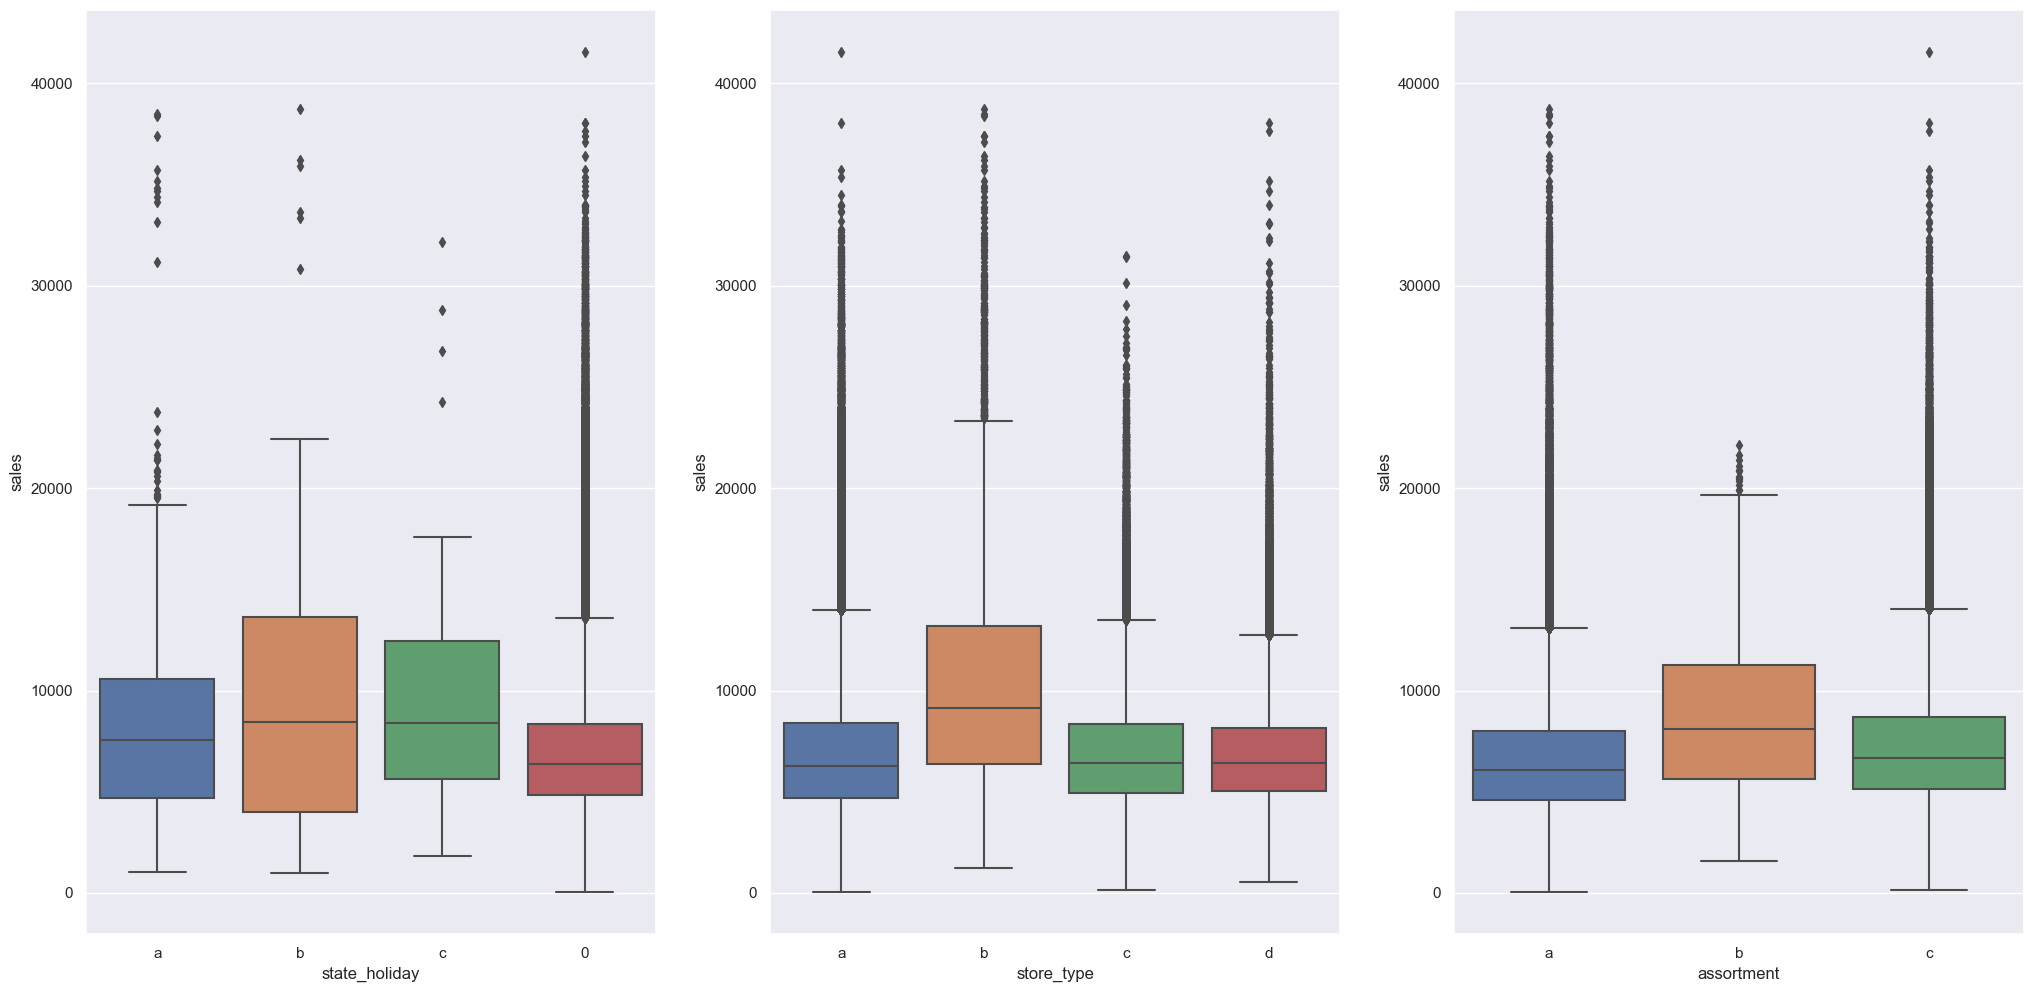

In [21]:
aux = df1[df1.sales > 0]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux, order=['a','b','c','0'])

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux, order=['a','b','c','d'])

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux, order=['a','b','c']);

# 2.0. ENGENHARIA DE FEATURES

In [22]:
df2 = df1.copy()

## 2.1. Formulação das Hipóteses

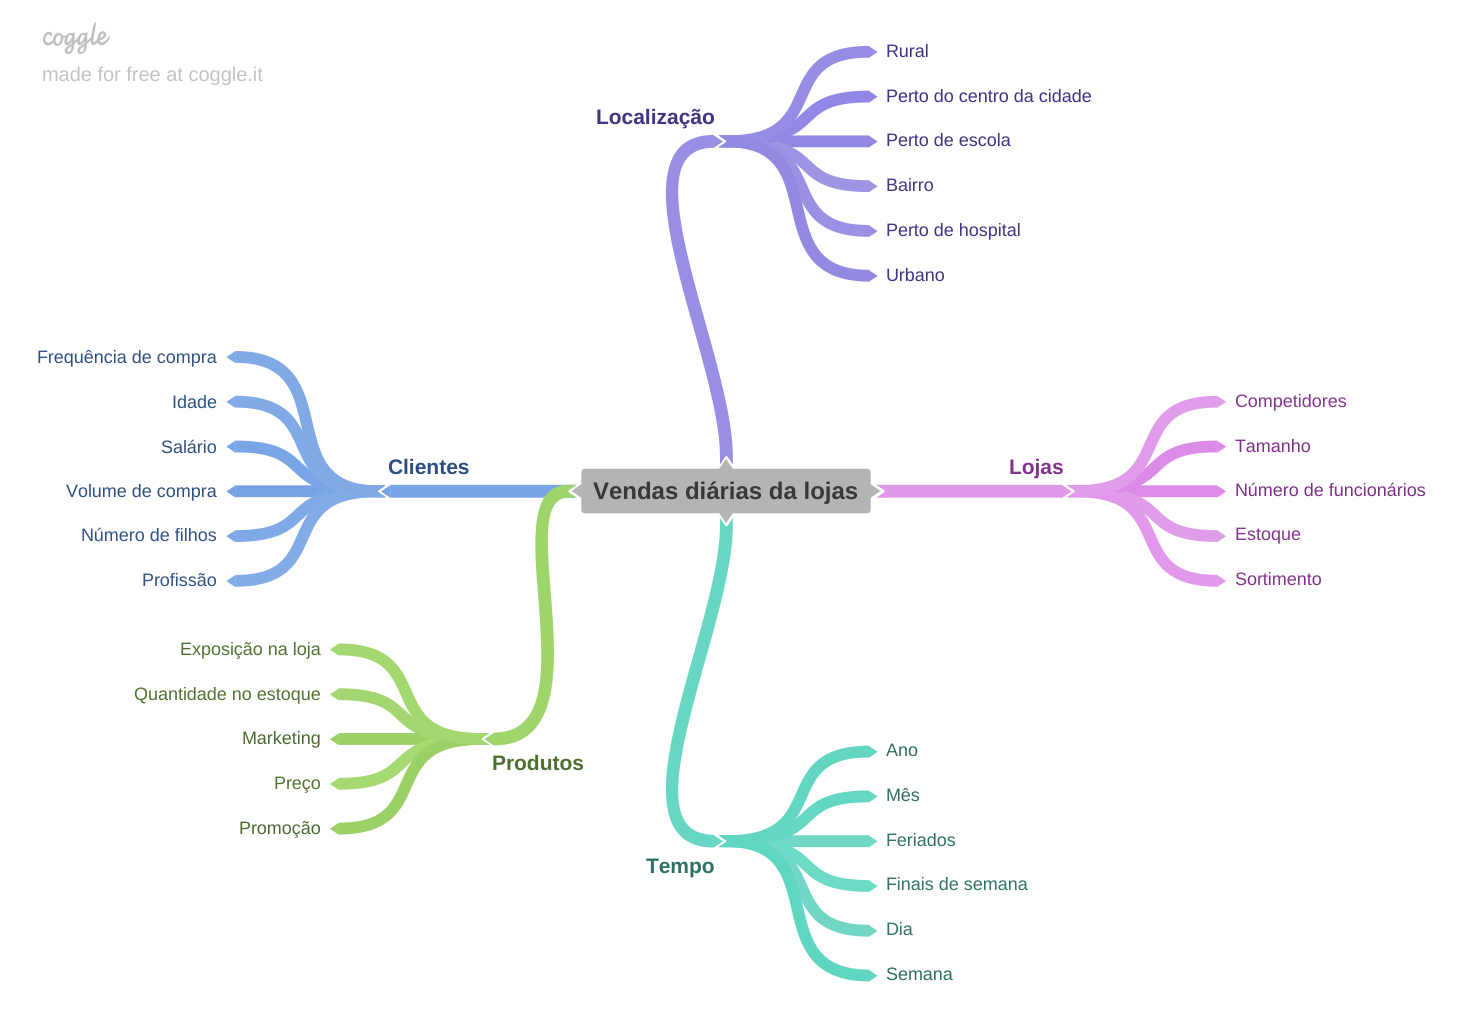

In [23]:
Image('img/mapa_mental_hipoteses.png')

### 2.1.1. Store Hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more

**3.** Bigger stores should sell more.

**4. Stores with greater assortment should sell more.**

**5. Stores with closer competitors should sell less.**

**6. Stores with competitors for a longer time should sell more.**

*OBS: Hypotheses in bold can be evaluated with currently available data.*

### 2.1.2. Product Hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6. Stores with promotions active for longer should sell more.**

**7. Stores with more promotion days should sell more.**

**8. Stores with more consecutive promotions should sell more.**

*OBS: Hypotheses in bold can be evaluated with currently available data.*

### 2.1.3. Time Hypotheses

**1. Stores open over the Christmas holiday should sell more.**

**2. Stores should sell more over the years.**

**3. Stores should sell more in the second half of the year.**

**4. Stores should sell more after the 10th of every month.**

**5. Stores should sell less on weekends.**

**6. Stores should sell less during school holidays.**

*OBS: Hypotheses in bold can be evaluated with currently available data.*

## 2.2. Engenharia de Features

In [24]:
# year
df2['year'] = df2['date'].dt.year

# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# year month
df2['year_month'] = df2['date'].dt.strftime('%Y-%m')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# competition time month
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).apply(lambda x: x.days)/30).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w'))

# promo time week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']).apply(lambda x: x.days)/7).astype(int)

# promo time day
df2['promo_time_day'] = (df2['date'] - df2['promo_since']).apply(lambda x: x.days)

# month_map
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['month_map'] = df2['date'].dt.month.map(month_map)

# is_promo
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas'      if x == 'c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

## 3.1. Filtragem de Linhas 

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem de Colunas

In [27]:
cols_drop = ['customers', 
             'open', 
             'promo_interval', 
             'month_map']

df3.drop(cols_drop, axis=1, inplace=True)

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [28]:
df4 = df3.copy()

## 4.1. Análise Univariado

### 4.1.1. Variável Resposta

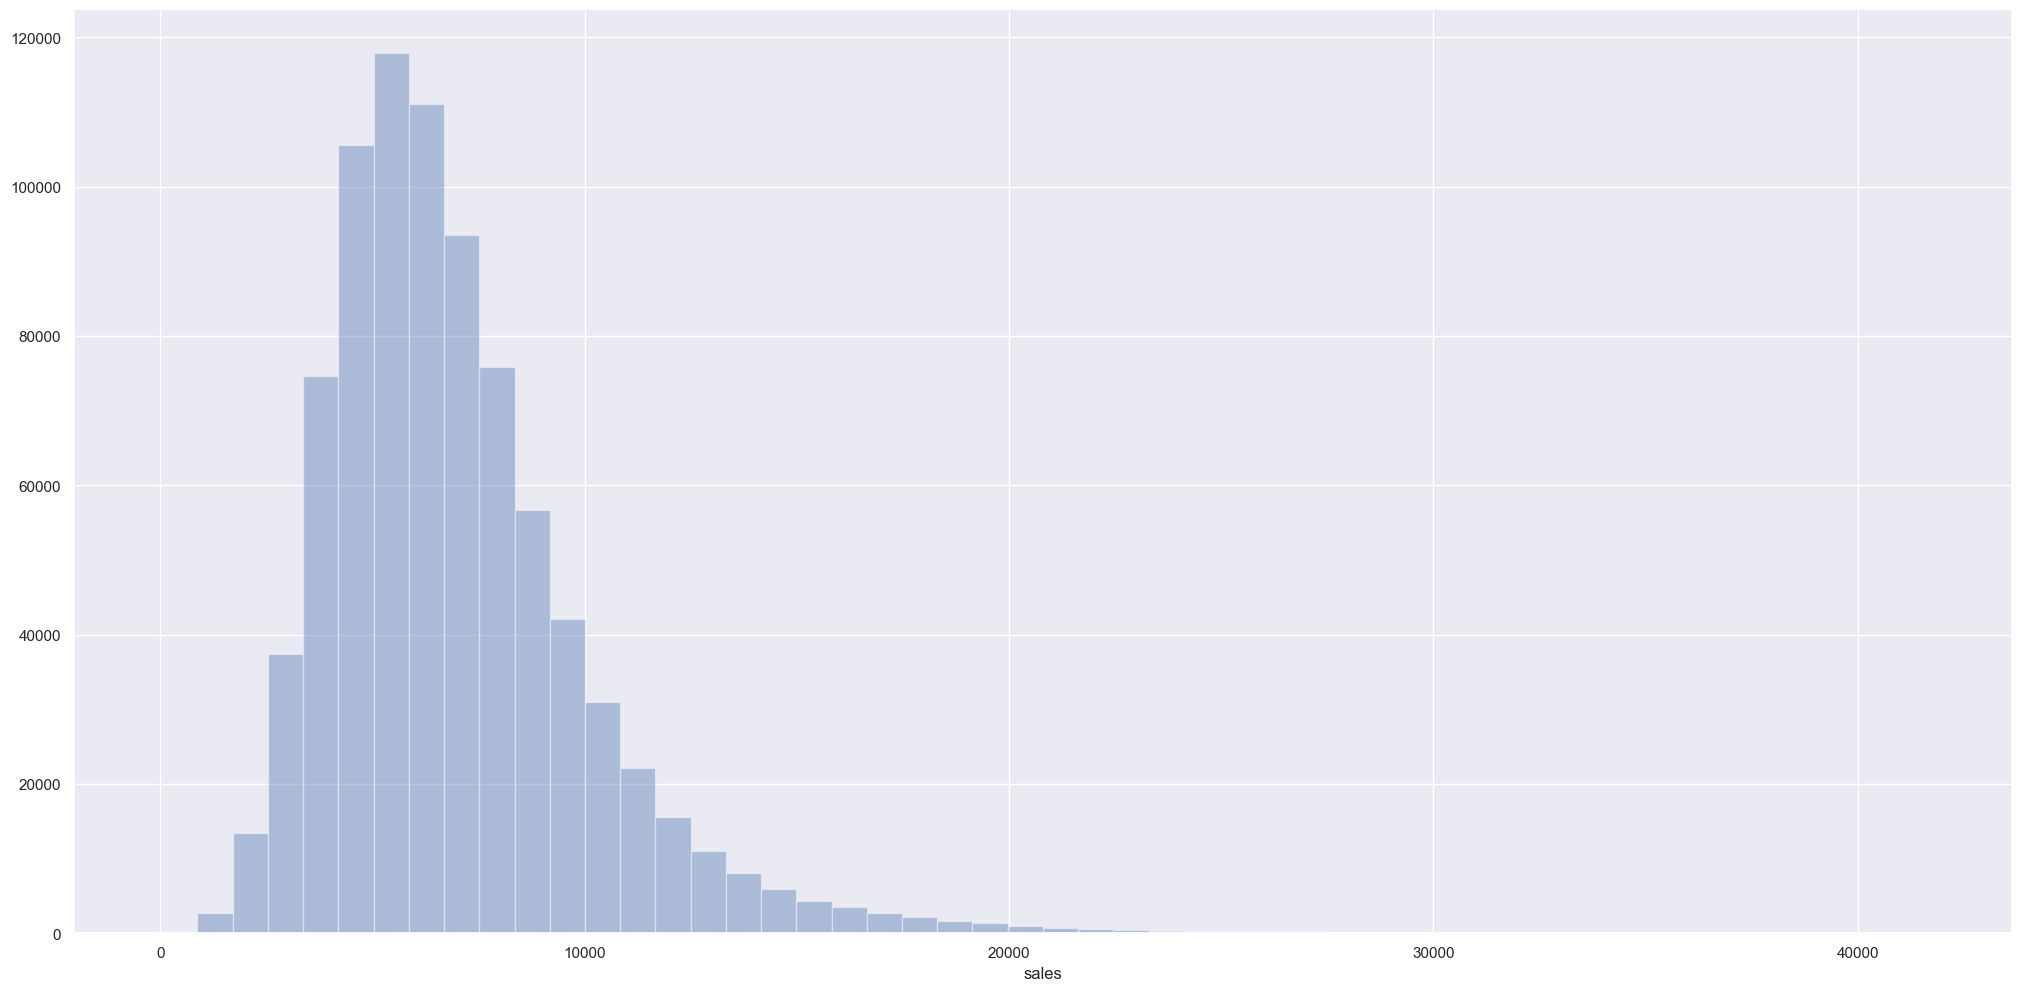

In [29]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2. Variáveis Numéricas

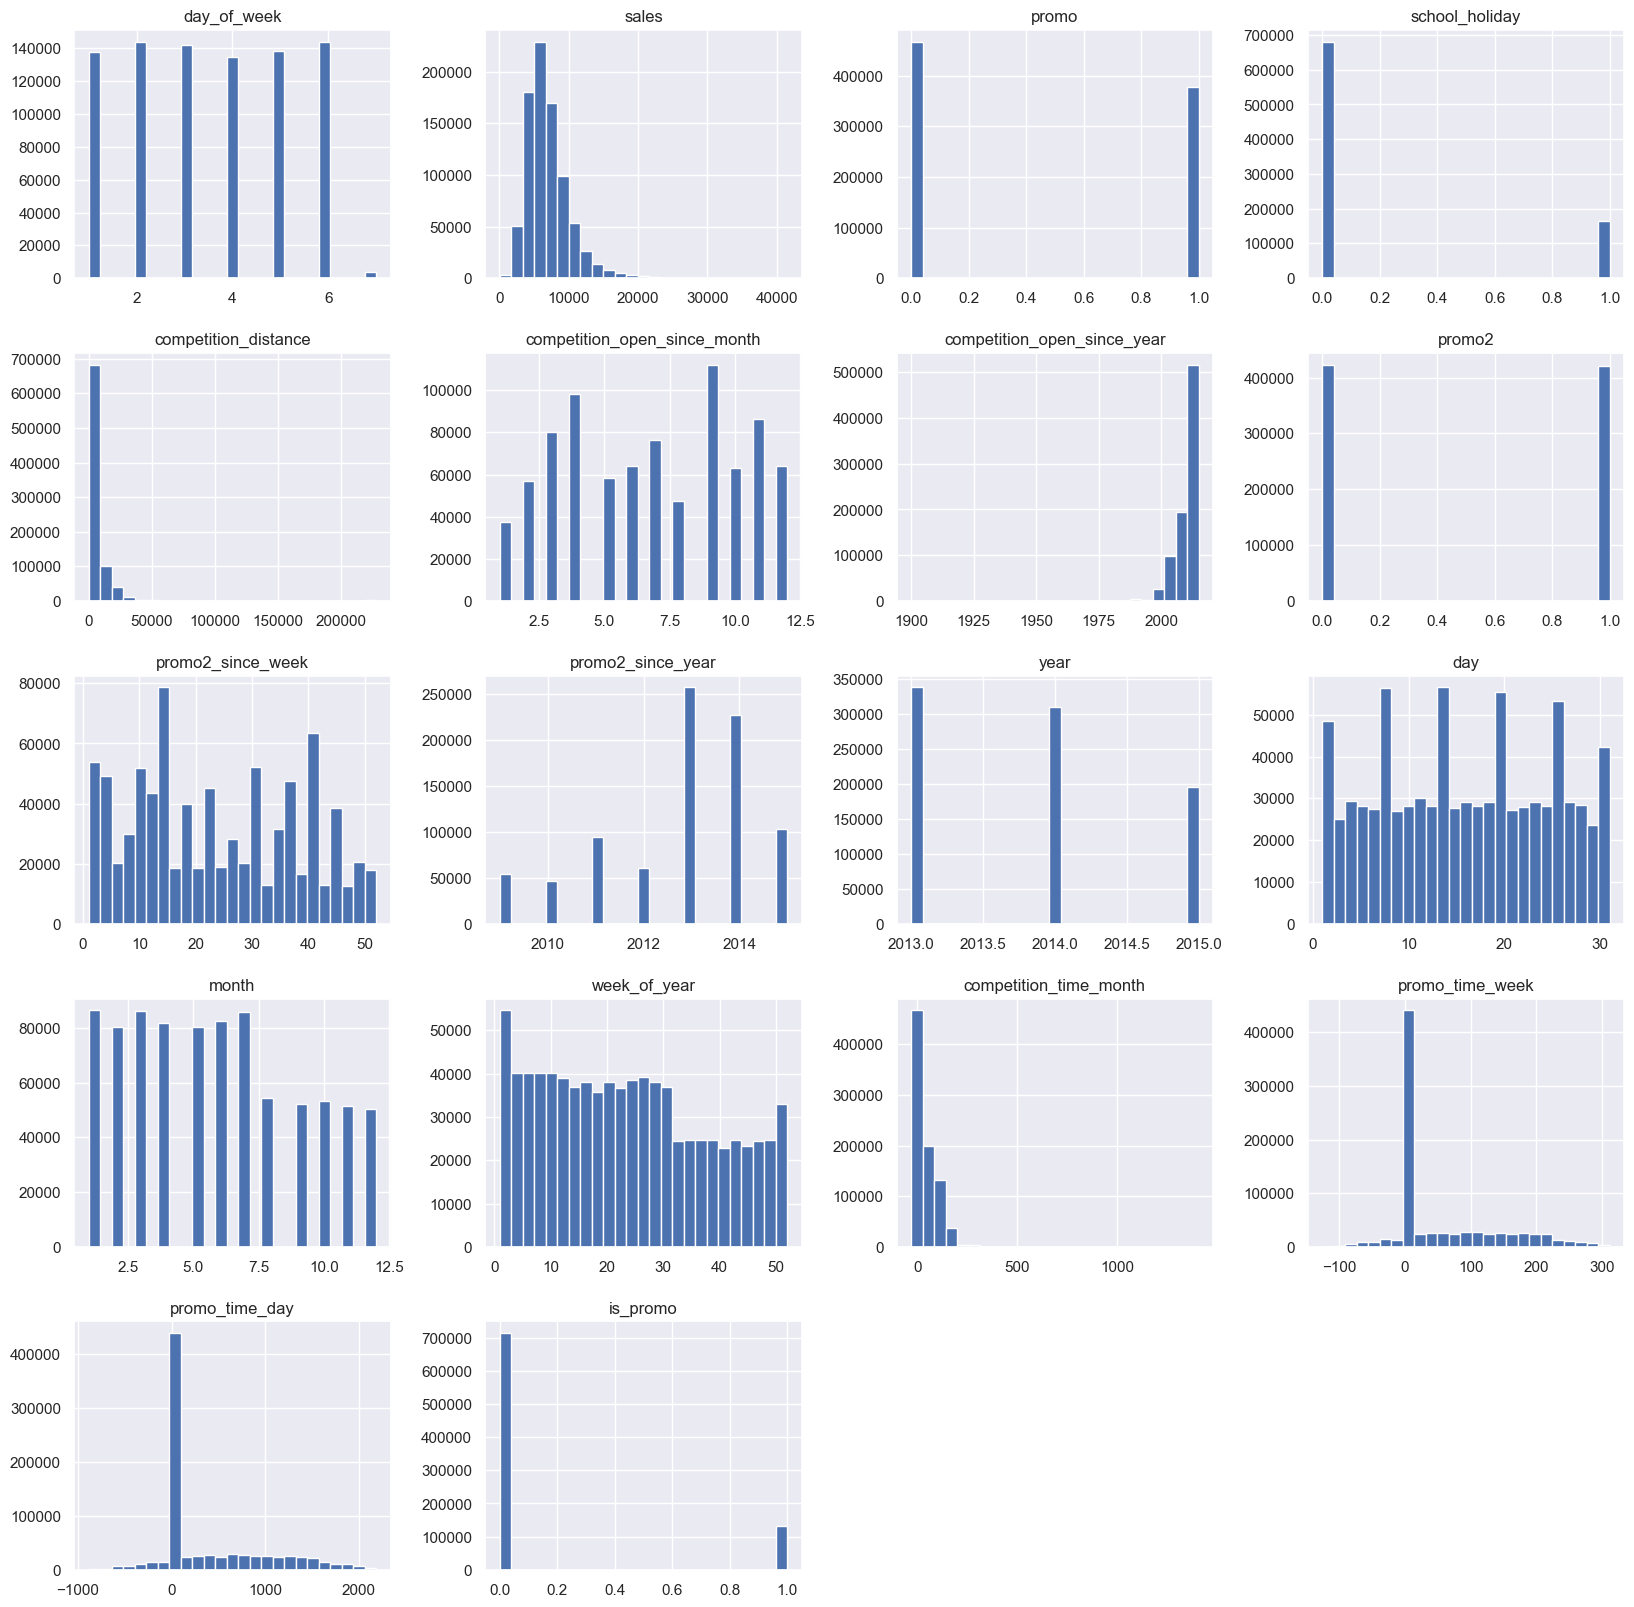

In [30]:
# atualizar num_attributes
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# apagar store
num_attributes.drop('store', axis=1, inplace=True)

# plot
num_attributes.hist(bins=25, figsize=(20,20));

### 4.1.3. Variáveis Categóricas

In [31]:
# atualizar atributos categóricos
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

# mostrar dataframe
cat_attributes.head()

,state_holiday,store_type,assortment,year_week,year_month
0,regular_day,c,basic,2015-30,2015-07
1,regular_day,a,basic,2015-30,2015-07
2,regular_day,a,basic,2015-30,2015-07
3,regular_day,c,extended,2015-30,2015-07
4,regular_day,a,basic,2015-30,2015-07


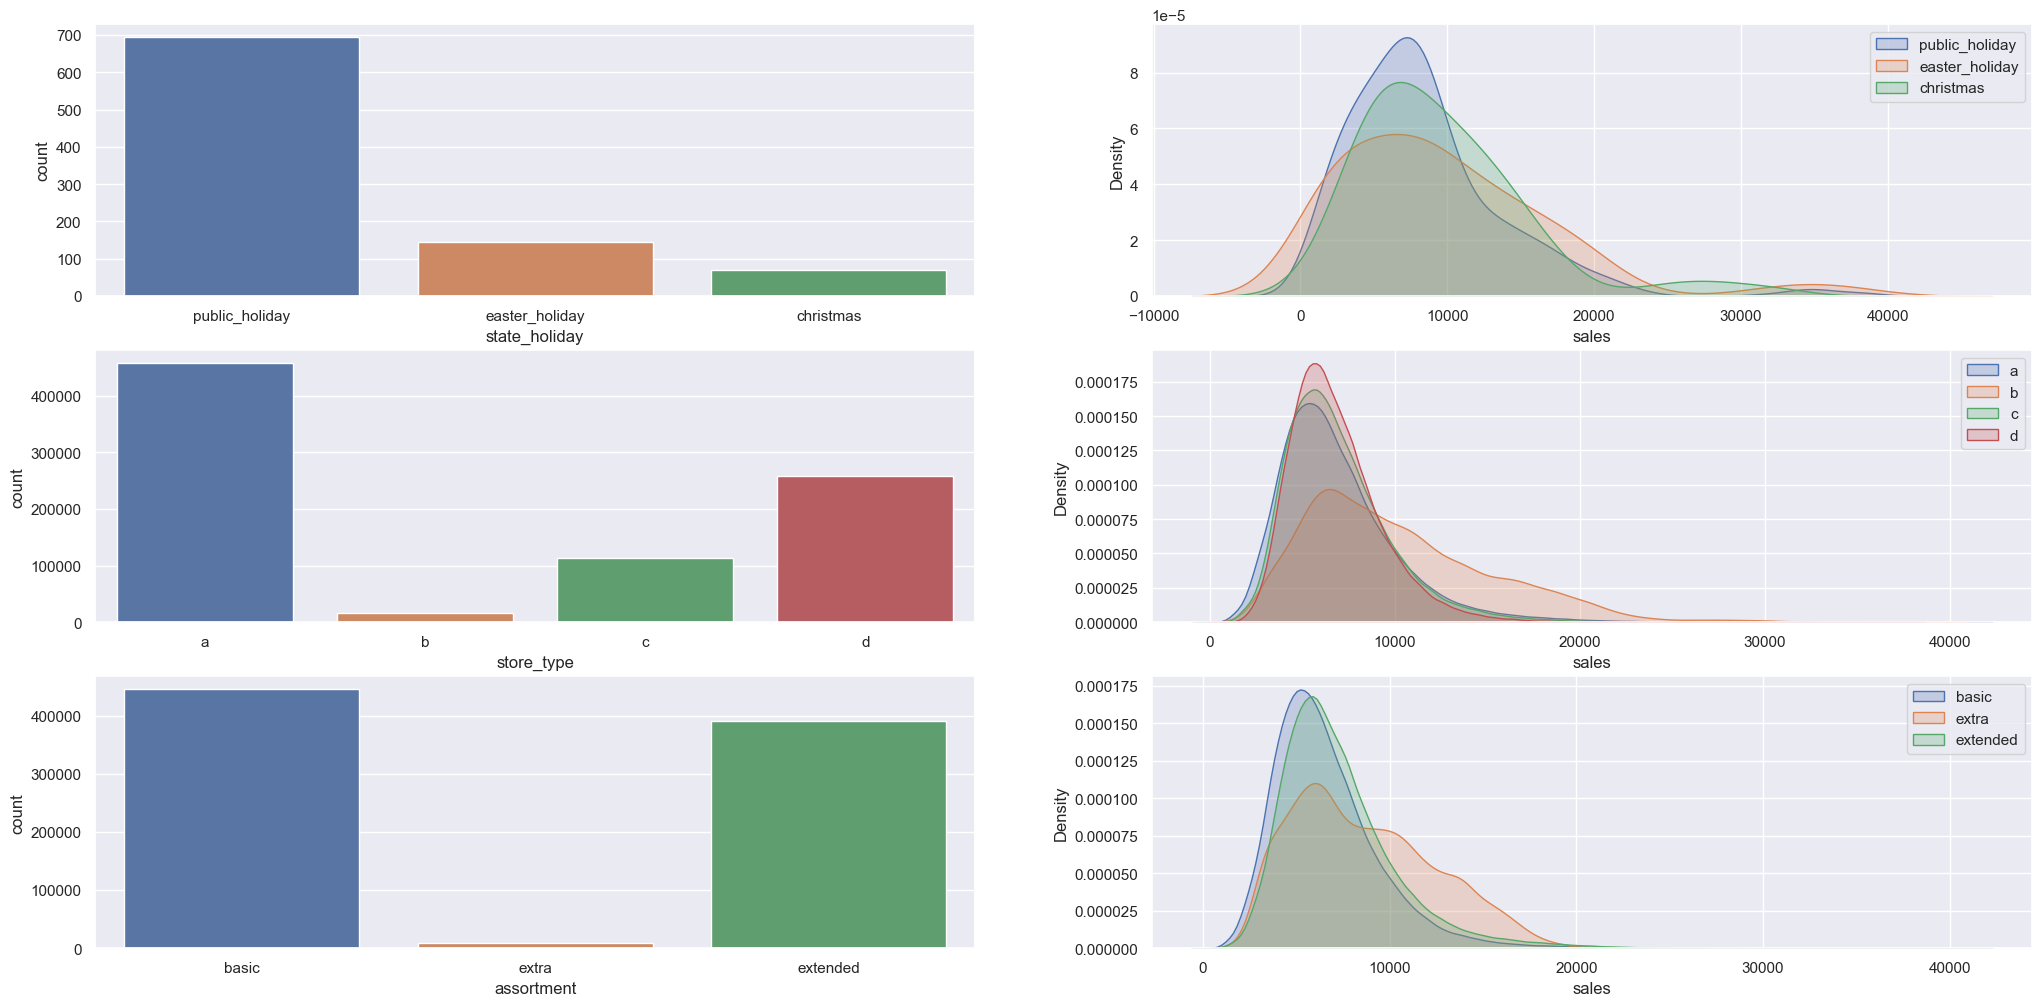

In [32]:
# lojas abertas nas férias
plt.subplot(3, 2, 1)
sns.countplot(data=df4[df4['state_holiday'] != 'regular_day'], x='state_holiday', order=['public_holiday','easter_holiday','christmas'])

# densidade de probabilidade de vendas nas férias
plt.subplot(3, 2, 2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday'], x='sales', label='public_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday'], x='sales', label='easter_holiday', shade=True)
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas'],      x='sales', label='christmas',      shade=True)
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x='store_type', order=['a','b','c','d'])

# densidade de probabilidade de vendas para tipos de lojas
plt.subplot(3, 2, 4)
sns.kdeplot(data=df4[df4['store_type'] == 'a'], x='sales', label='a', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'b'], x='sales', label='b', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'c'], x='sales', label='c', shade=True)
sns.kdeplot(data=df4[df4['store_type'] == 'd'], x='sales', label='d', shade=True)
plt.legend()

# lojas por tipo de sortimento
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x='assortment', order=['basic','extra','extended'])

# densidade de probabilidade de vendas para tipos de sortimentos
plt.subplot(3, 2, 6)
sns.kdeplot(data=df4[df4['assortment'] == 'basic'],    x='sales', label='basic',    shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extra'],    x='sales', label='extra',    shade=True)
sns.kdeplot(data=df4[df4['assortment'] == 'extended'], x='sales', label='extended', shade=True)
plt.legend();

## 4.2. Análise Bivariado

### 4.2.1. Validação de Hipóteses

#### **H1.** Lojas com maior sortimento deveriam vender mais.

**VERDADEIRA**

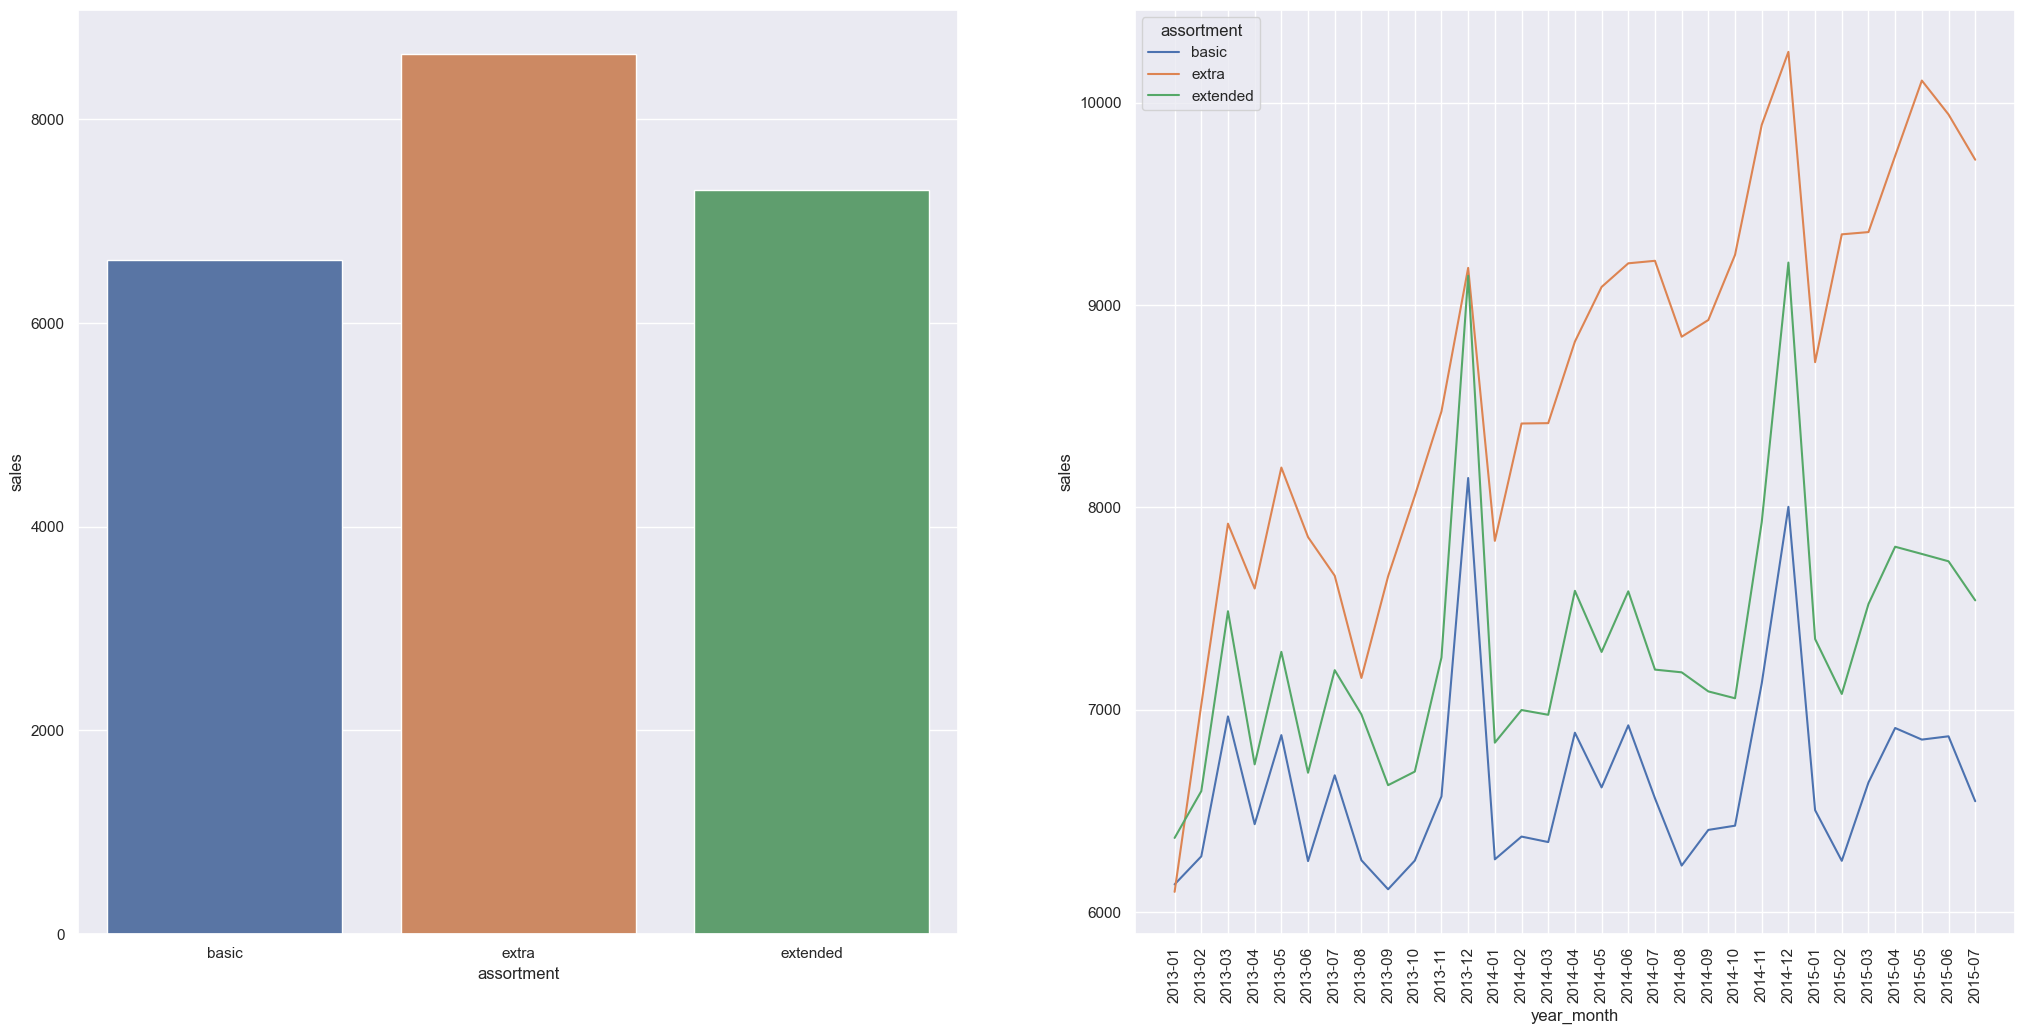

In [33]:
plt.subplot(1,2,1)
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales', order=['basic','extra','extended']);

plt.subplot(1,2,2)
aux2 = df4[['assortment','sales','year_month']].groupby(['year_month','assortment']).mean().reset_index()
sns.lineplot(data=aux2, x='year_month', y='sales', hue='assortment', hue_order=['basic','extra','extended']);
plt.xticks(rotation=90);

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com competidores mais próximos vendem, em média, igual que os mais distantes.

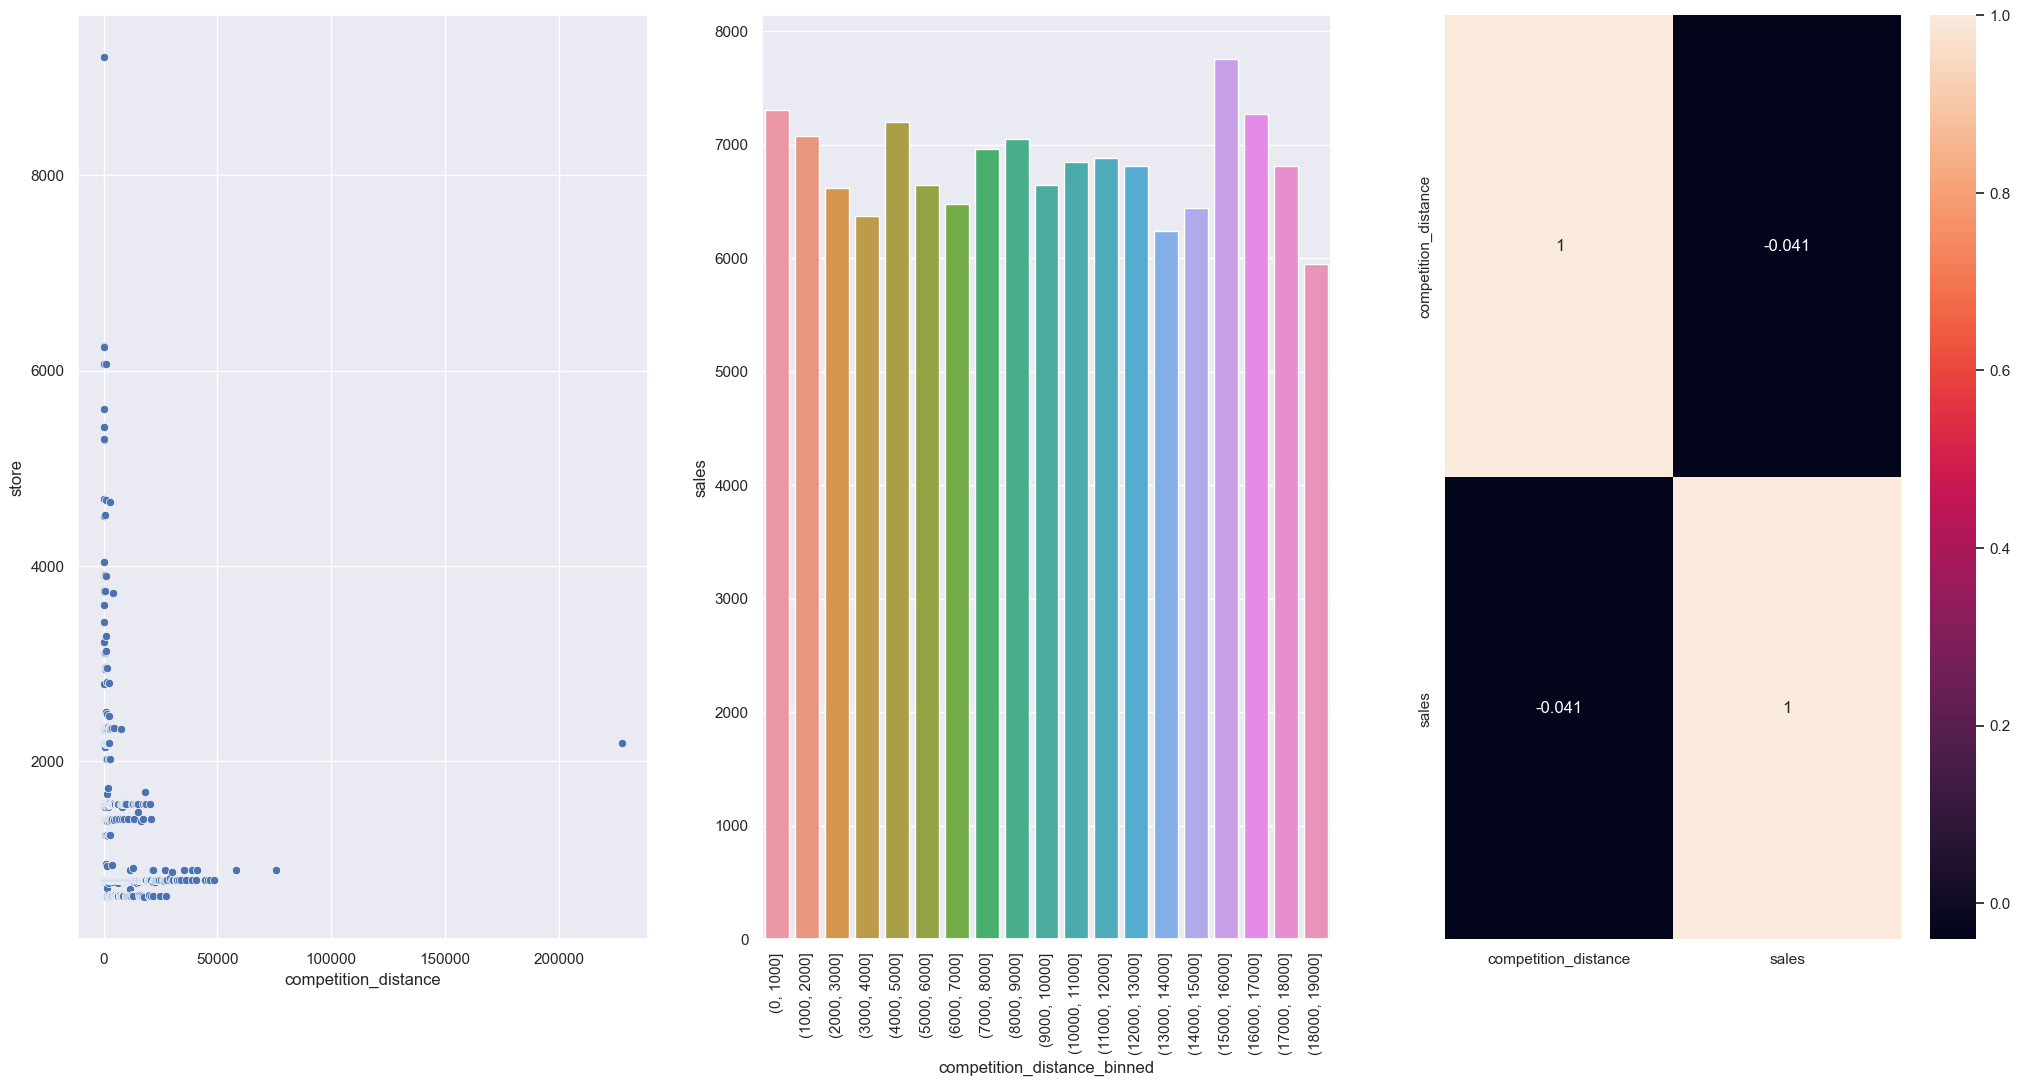

In [34]:
plt.subplot(1, 3, 1)
aux1=df4.loc[df4['competition_distance'] < 2e6,['competition_distance','store']].groupby('competition_distance').count().reset_index()
sns.scatterplot( x ='competition_distance', y='store', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
df4['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins=bins)
aux1 = df4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux1);
plt.xticks(rotation=90);
df4.drop('competition_distance_binned', axis=1, inplace=True)

plt.subplot(1, 3, 3)
aux3 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
sns.heatmap(df4[['competition_distance', 'sales']].corr( method='pearson' ), annot=True);

#### **H3.** Lojas com competidores há mais tempo deveriam vendem mais.

**FALSA** Lojas com competidores há mais tempo vendem, em média, igual.

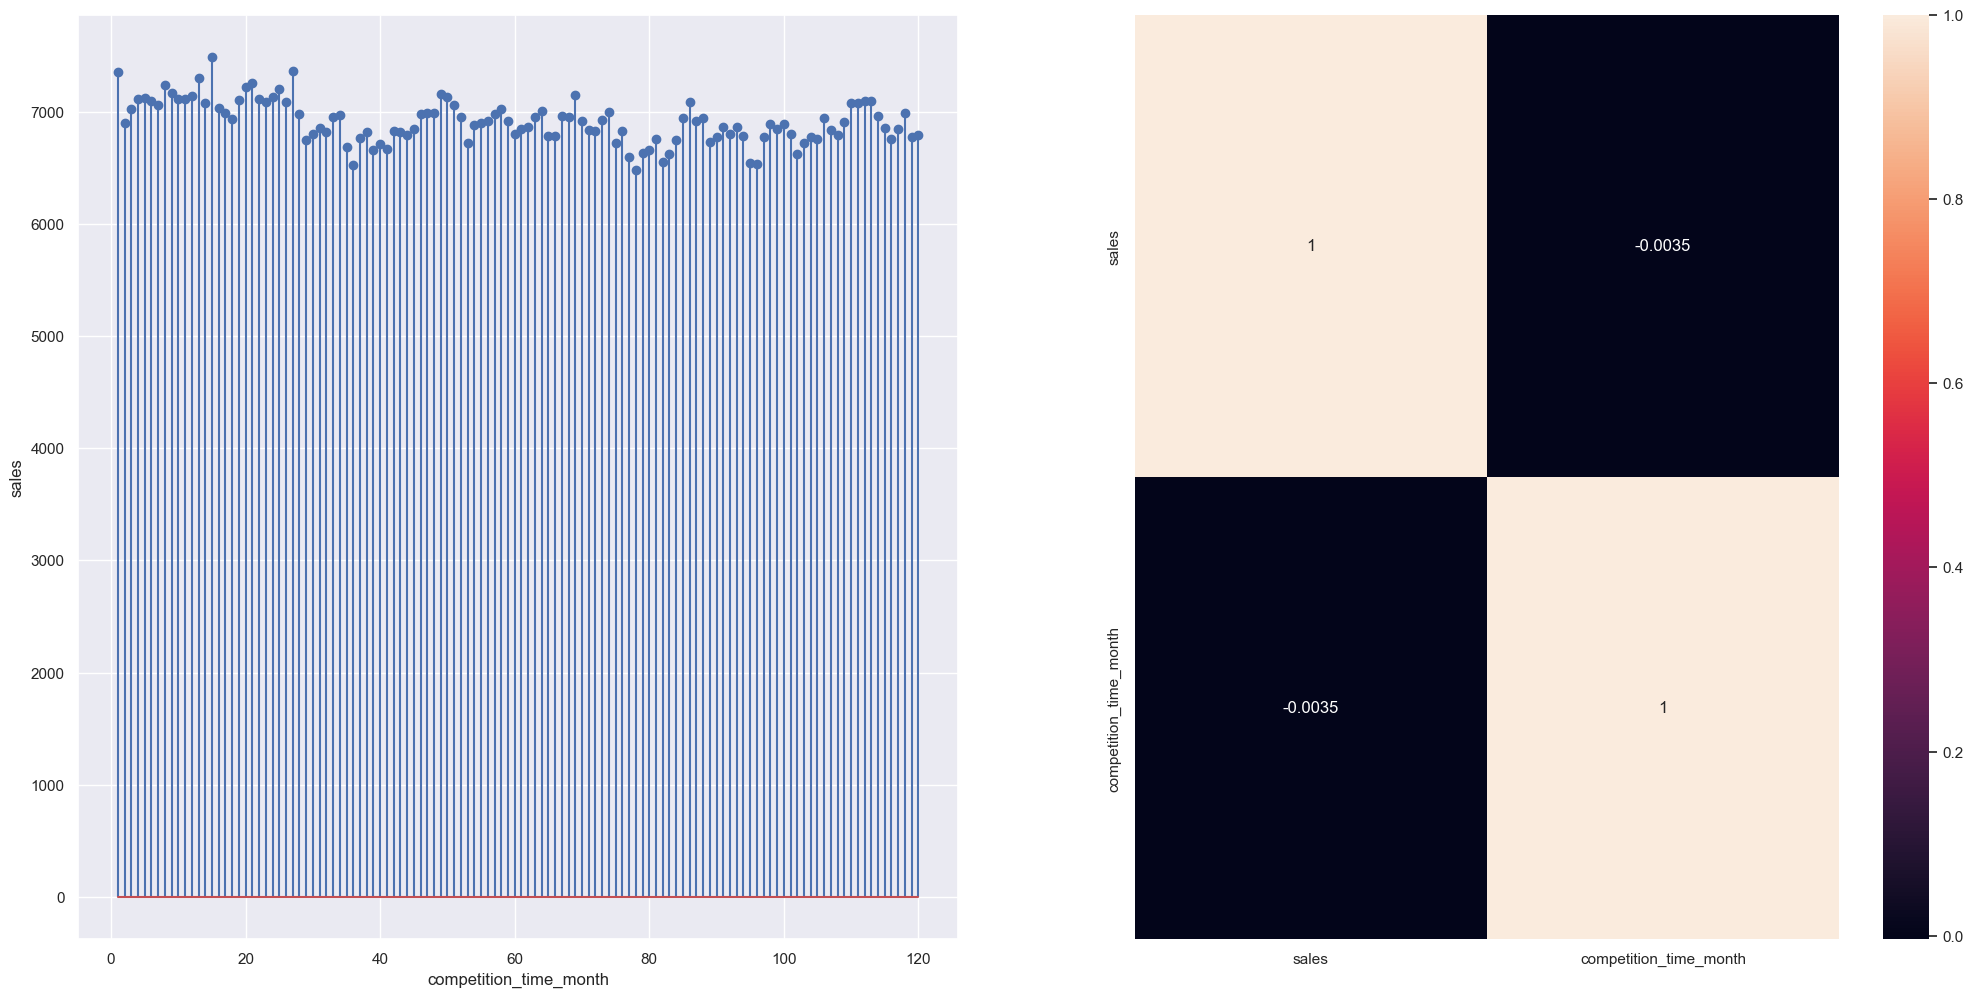

In [35]:
plt.subplot(1, 2, 1)
aux1 = df4[['sales','competition_time_month']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] > 0) & (aux1['competition_time_month'] <= 120) & (aux1['competition_time_month'] != 0)]
plt.stem(aux2['competition_time_month'], aux2['sales'])
plt.xlabel('competition_time_month')
plt.ylabel('sales')
        
plt.subplot(1, 2, 2)
sns.heatmap(df4[['sales','competition_time_month']].corr( method='pearson'), annot=True);

#### **H4.**  Lojas com promoções ativas por mais tempo deveriam vender mais.

**VERDADEIRA**

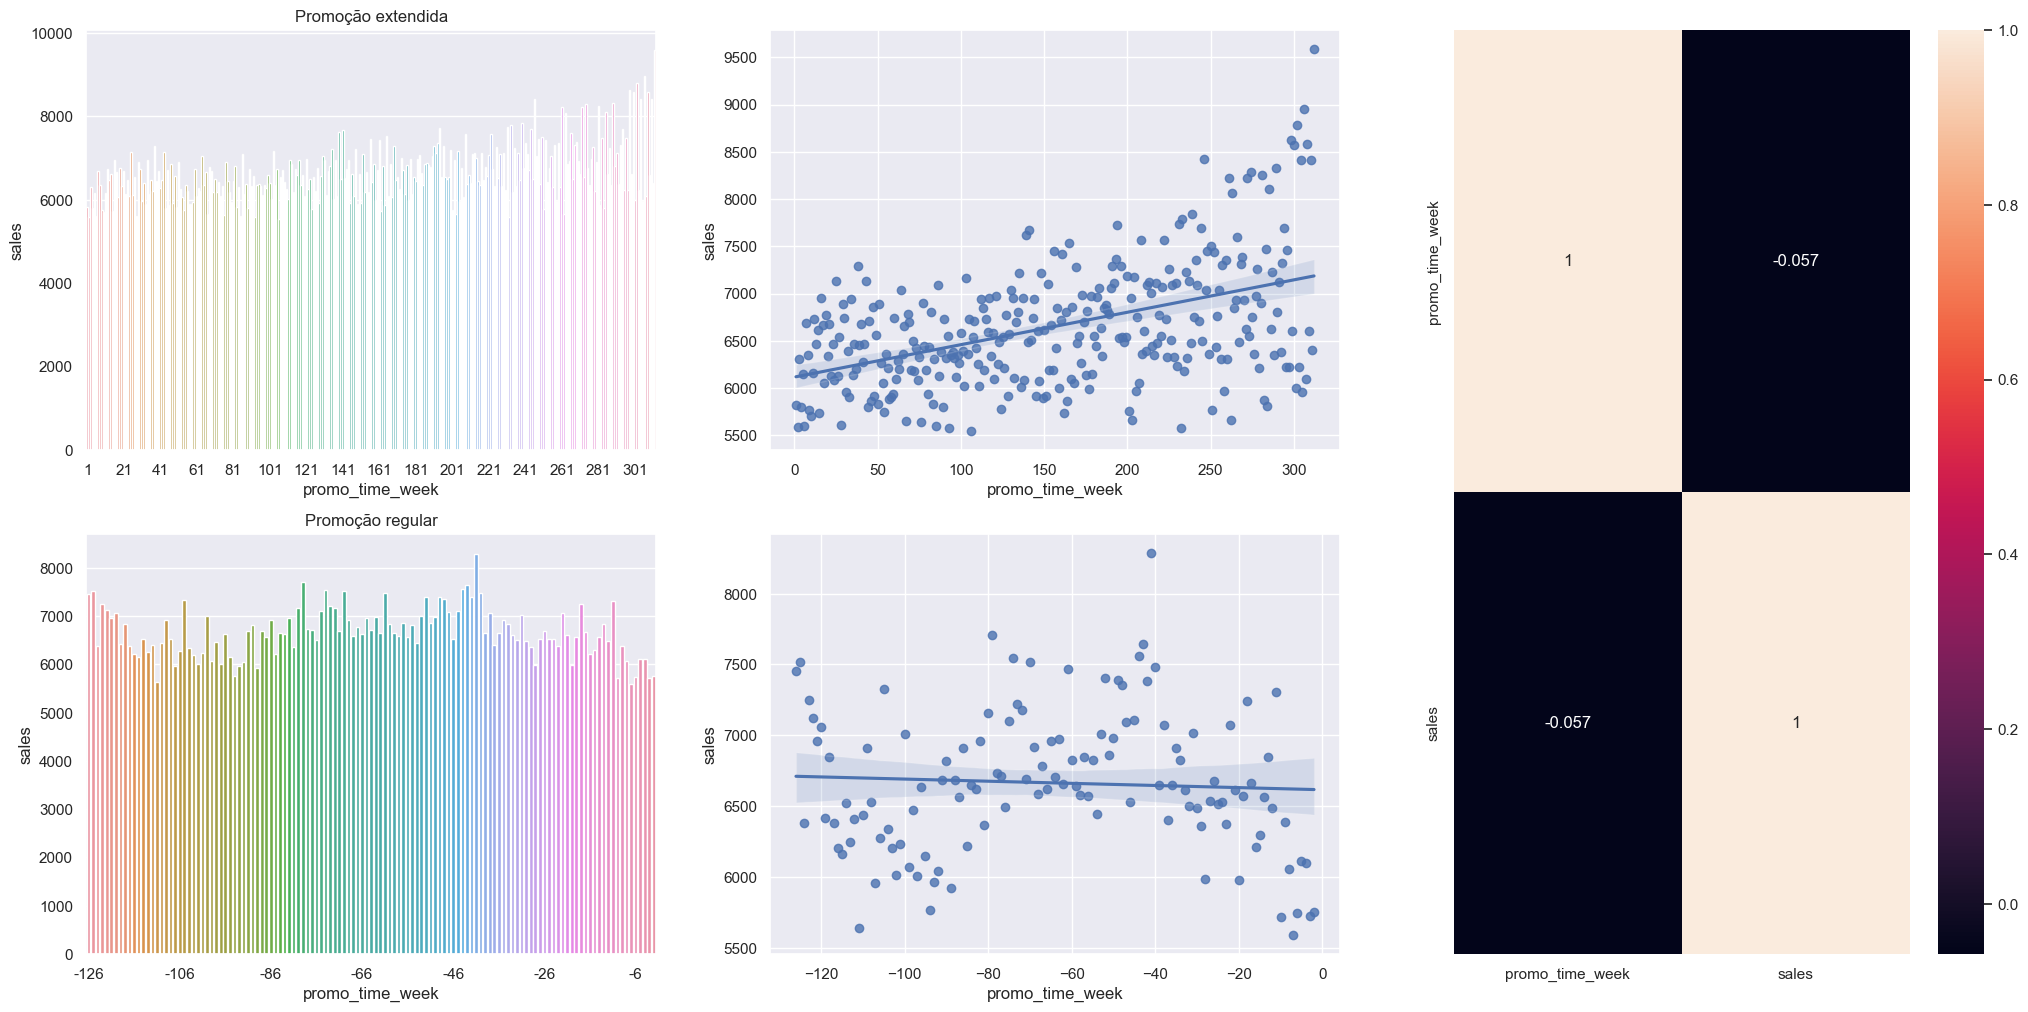

In [36]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])

# promoção extendida
aux2 = aux1[aux1['promo_time_week'] > 0]
ax=sns.barplot(data=aux2, x='promo_time_week', y='sales');
ax.set(title='Promoção extendida')
# diminuir densidade de x-ticks
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales')

plt.subplot(grid[1,0])

# promoção regular 
aux3 = aux1[aux1['promo_time_week'] < -1]
ax2=sns.barplot( x='promo_time_week', y='sales', data=aux3 );
ax2.set(title='Promoção regular')
# diminuir densidade de x-ticks
for ind, label in enumerate(ax2.get_xticklabels()):
    if ind % 20 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(grid[:,2])
sns.heatmap(df4[['promo_time_week','sales']].corr(method='pearson'), annot=True);

#### **H5.** Lojas com mais dias de promoção deveriam vender mais.

**VERDADEIRA**

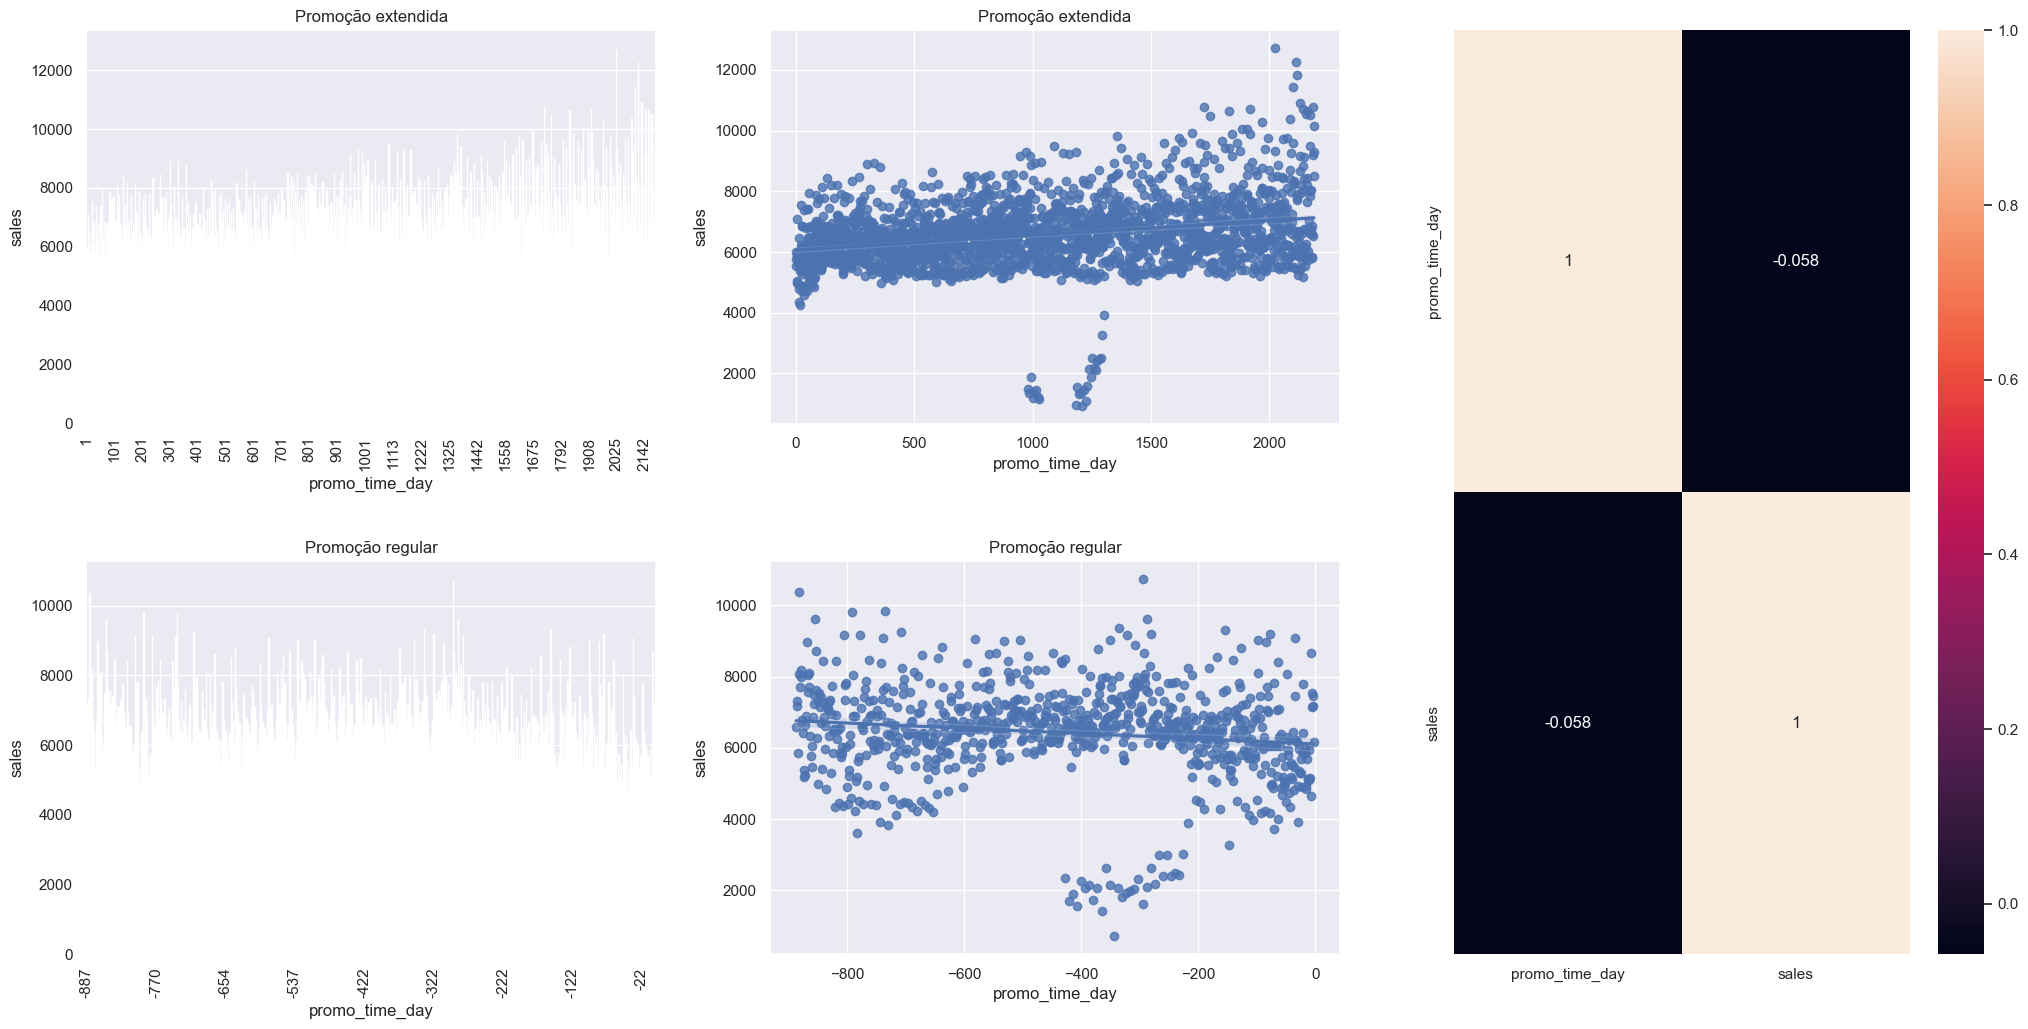

In [37]:
aux1 = df4[['promo_time_day','sales']].groupby('promo_time_day').mean().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])

# promoção extendida
aux2 = aux1[aux1['promo_time_day'] > 0]
ax=sns.barplot(data=aux2, x='promo_time_day', y='sales');
ax.set(title='Promoção extendida')
# diminuir densidade de x-ticks
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 100 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=90)        

plt.subplot(grid[0,1])
ax1=sns.regplot(data=aux2, x='promo_time_day', y='sales')
ax1.set(title='Promoção extendida')

plt.subplot(grid[1,0])
# promoção regular
aux3 = aux1[aux1['promo_time_day'] < -1]
ax2=sns.barplot( x='promo_time_day', y='sales', data=aux3 );
ax2.set(title='Promoção regular')
# diminuir densidade de x-ticks
for ind, label in enumerate(ax2.get_xticklabels()):
    if ind % 100 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=90)        
        
plt.subplot(grid[1,1])
ax3=sns.regplot( x='promo_time_day', y='sales', data=aux3 );
ax3.set(title='Promoção regular')

plt.subplot(grid[:,2])
sns.heatmap(df4[['promo_time_day','sales']].corr(method='pearson'), annot=True);

# separação horizontal entre subplots
plt.subplots_adjust(hspace=0.35)

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com mais promoções consecutivas vendem menos.

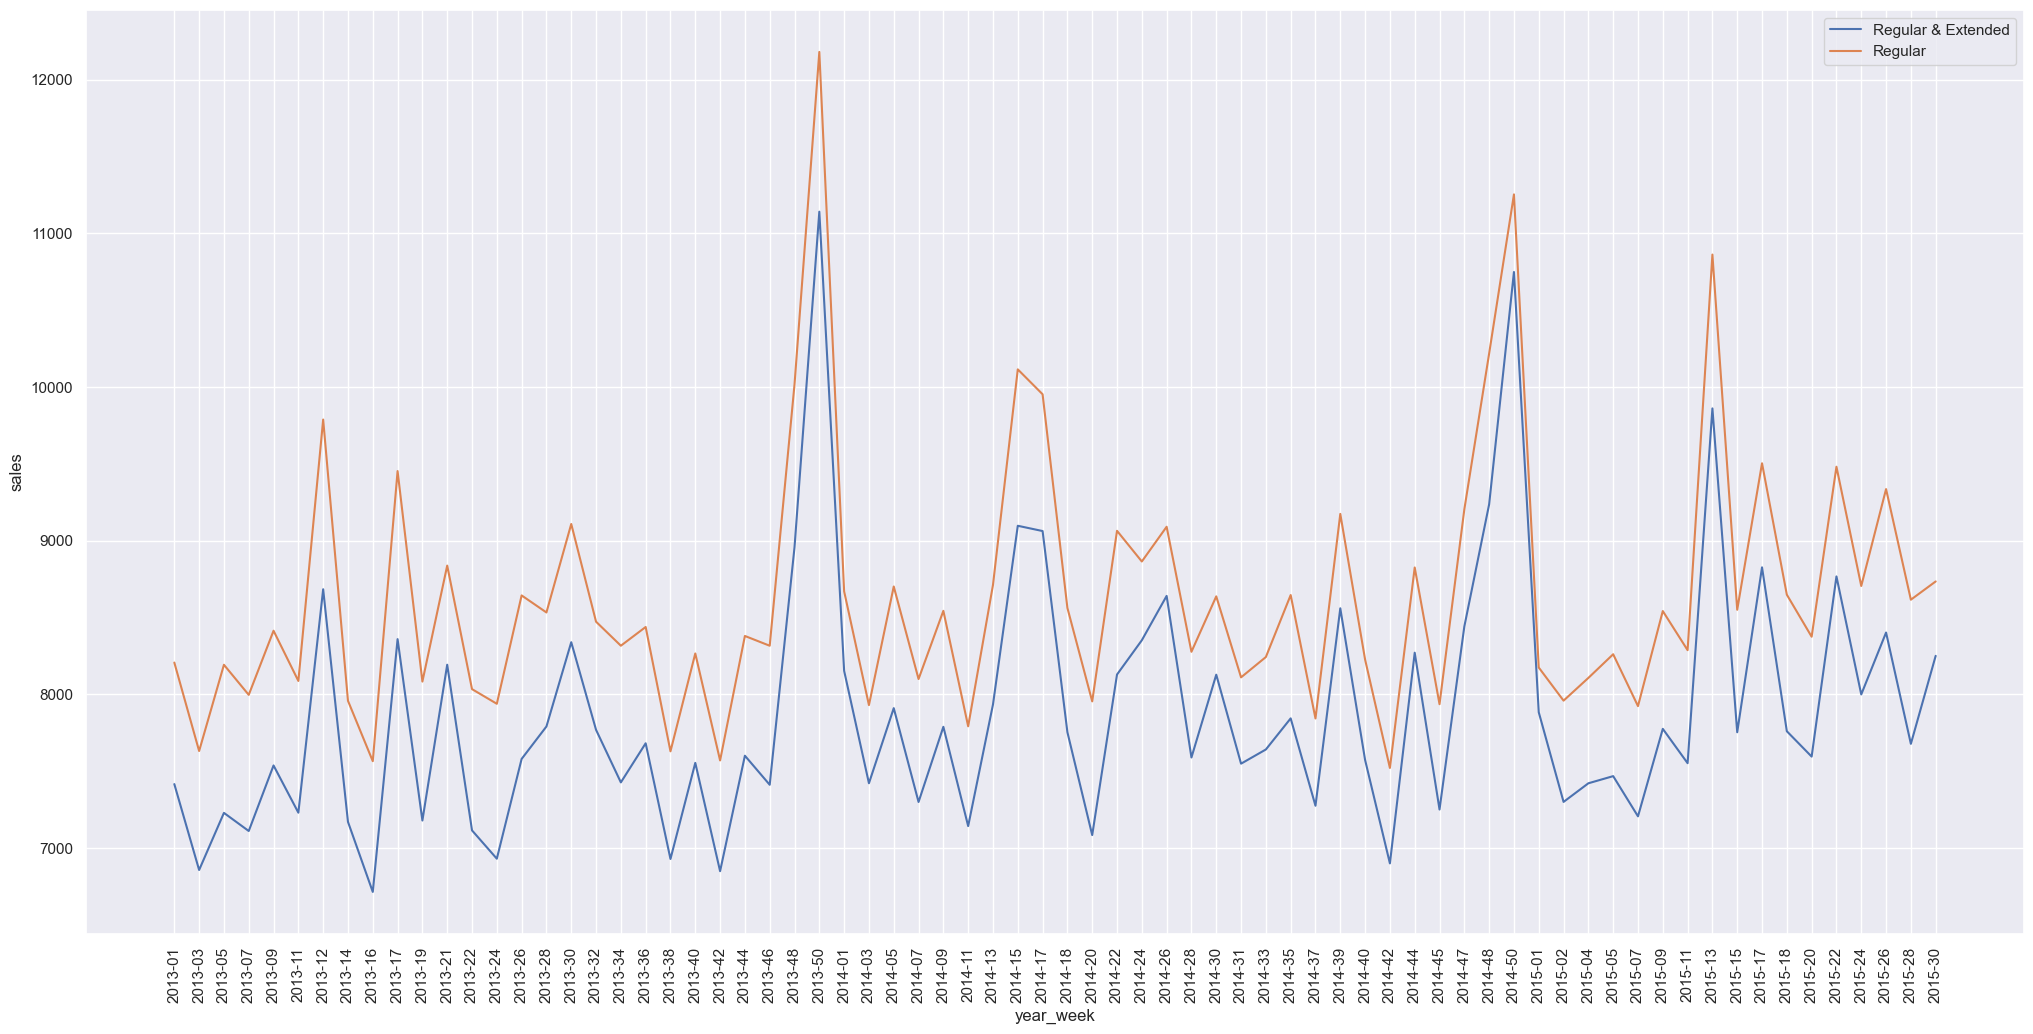

In [38]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = sns.lineplot(data=aux1, x='year_week',y='sales',label='Regular & Extended')

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax2 = sns.lineplot(data=aux2, x='year_week',y='sales',label='Regular')

plt.legend()
plt.xticks(rotation=90);

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

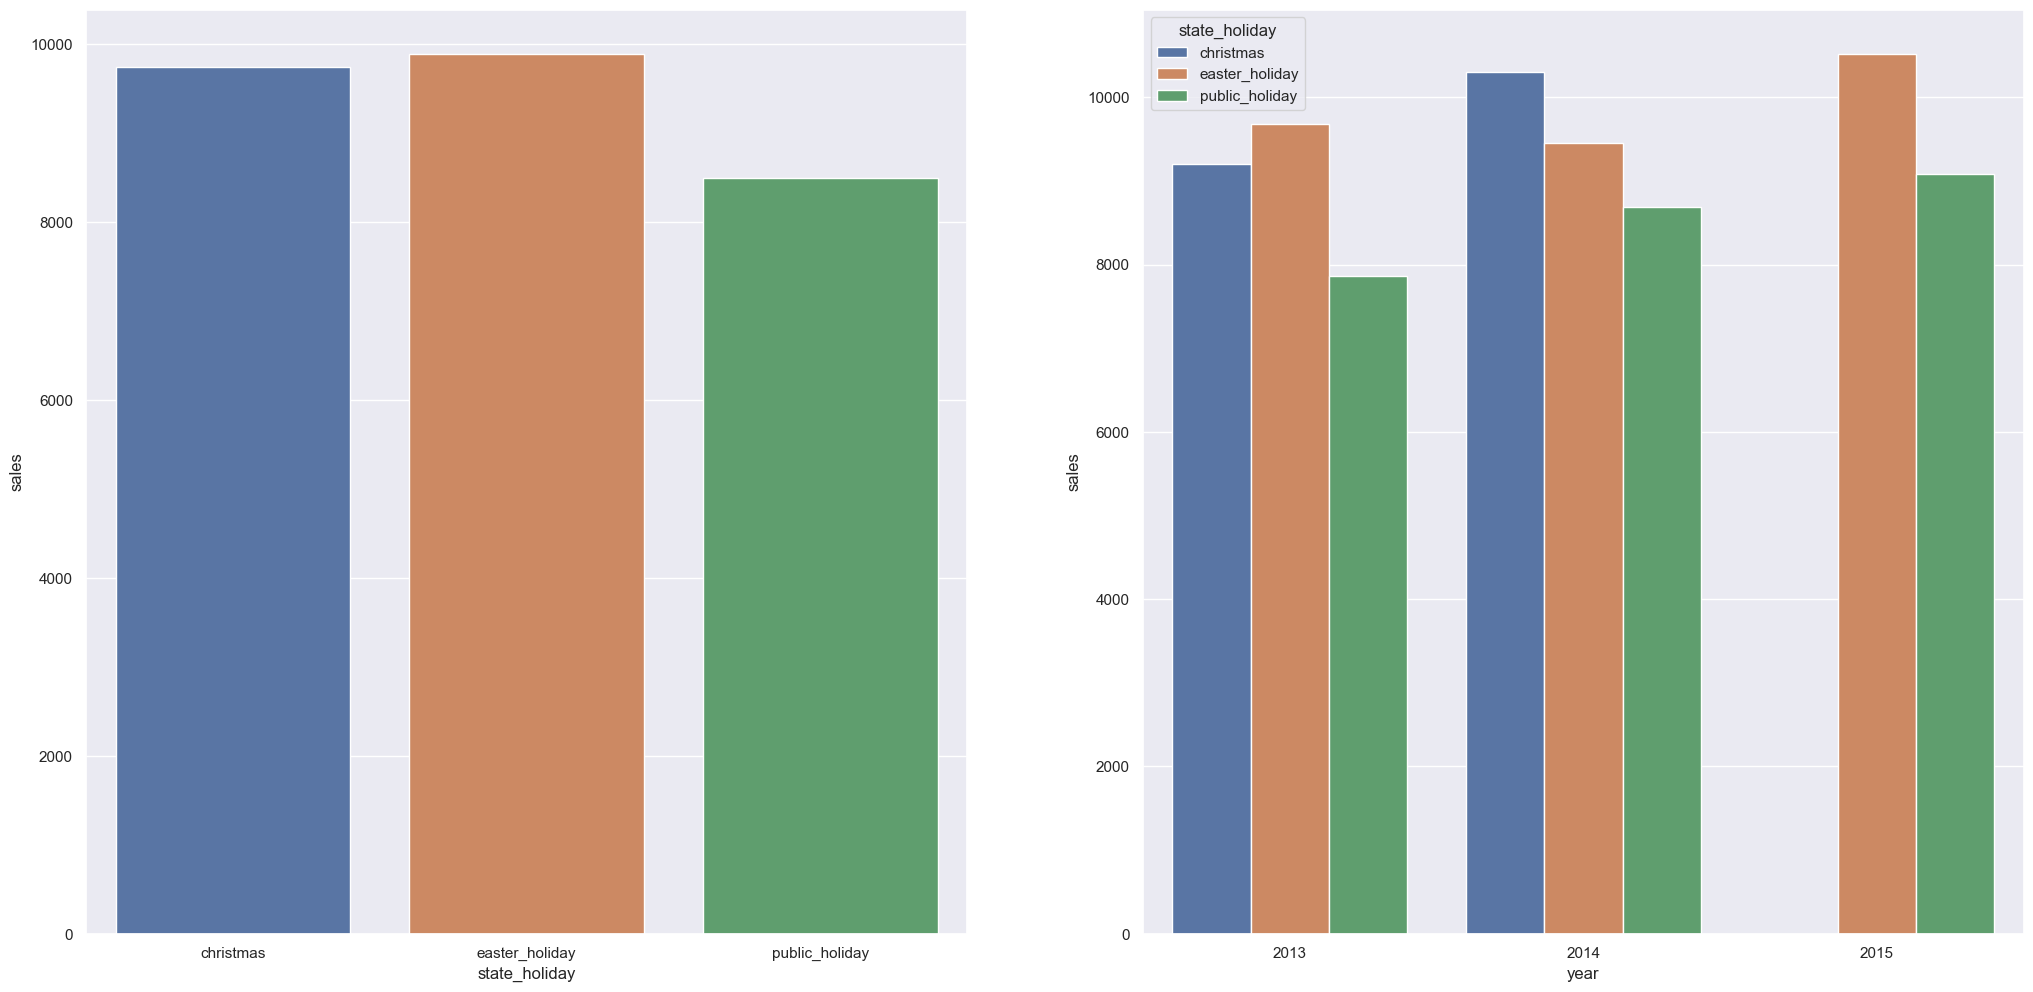

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1=aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(data=aux1,x='state_holiday',y='sales');

plt.subplot(1,2,2)
aux2=aux[['state_holiday','sales','year']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**VERDADEIRA**

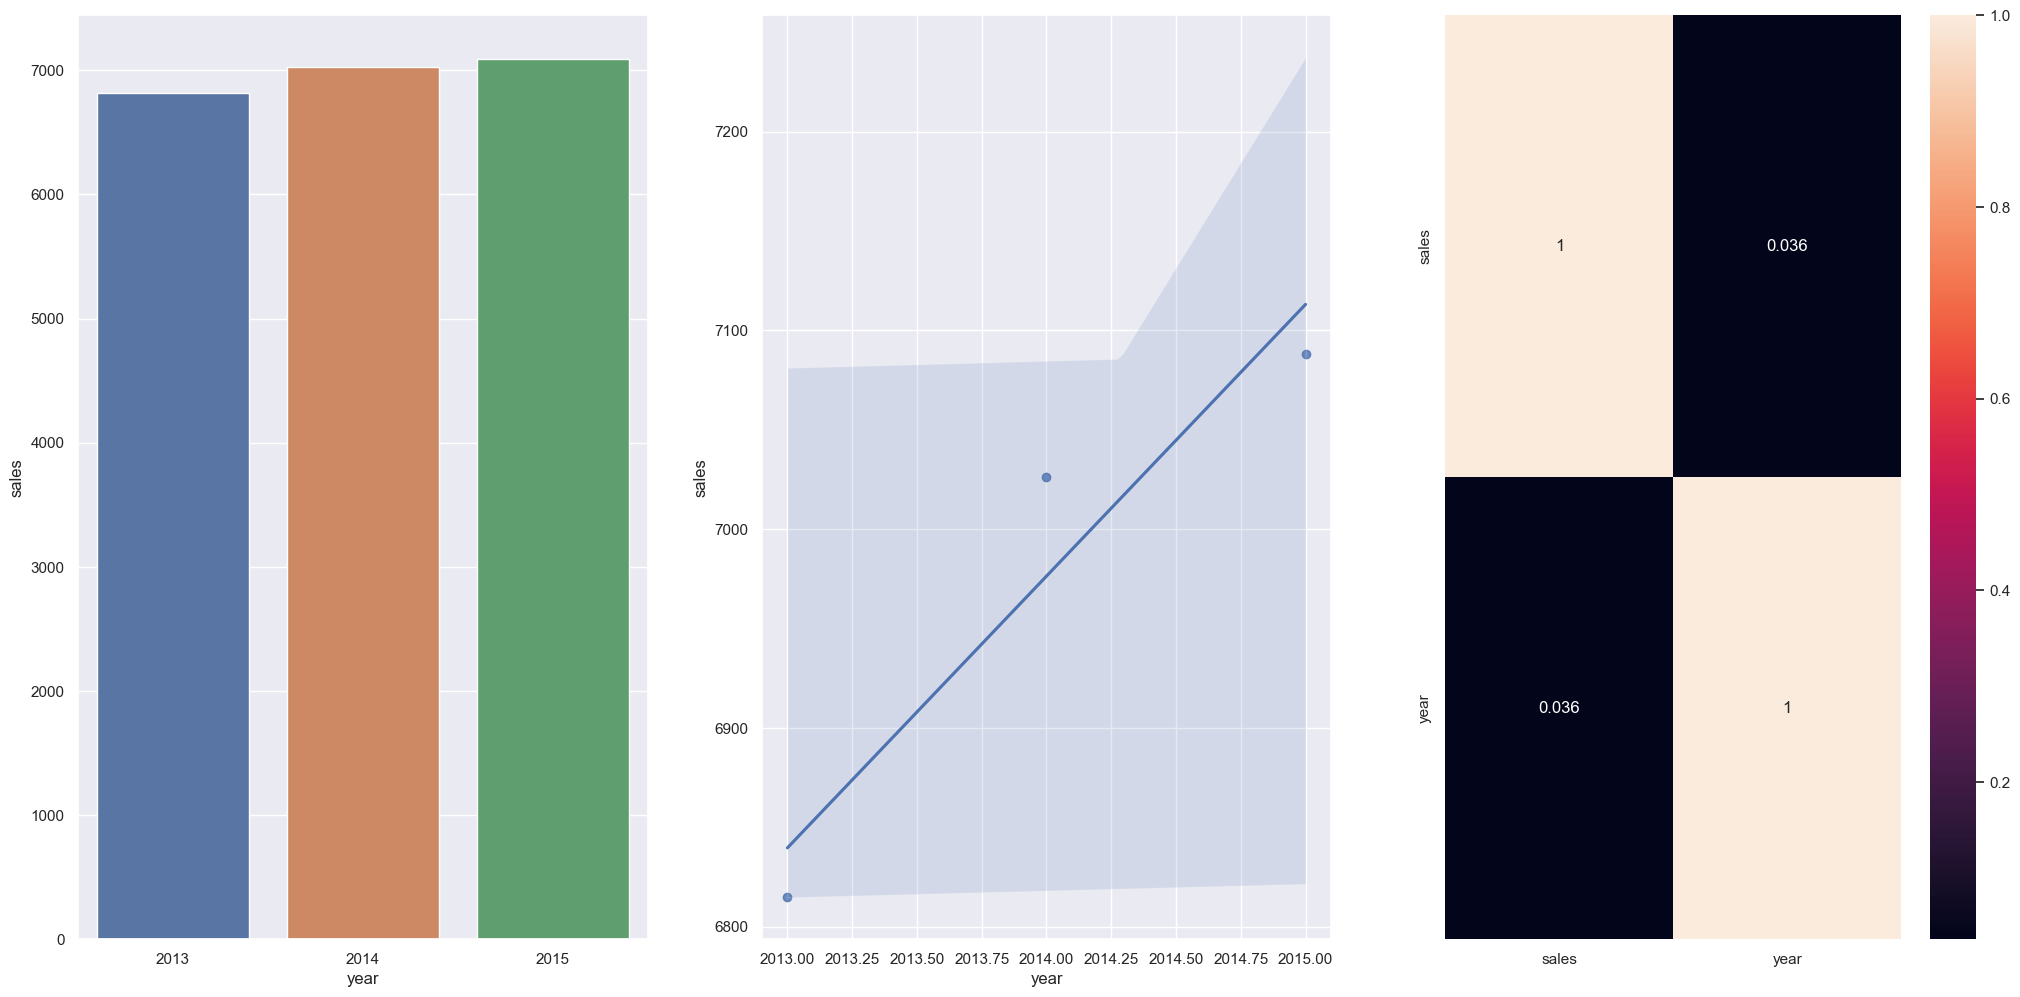

In [40]:
plt.subplot(1,3,1)
aux1=df4[['sales','year']].groupby('year').mean().reset_index()
sns.barplot(data=aux1,x='year',y='sales')

plt.subplot(1,3,2)
sns.regplot(data=aux1,x='year',y='sales')

plt.subplot(1,3,3)
sns.heatmap(df4[['sales','year']].corr(method='pearson'), annot=True);

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem menos no segundo semestre do ano.

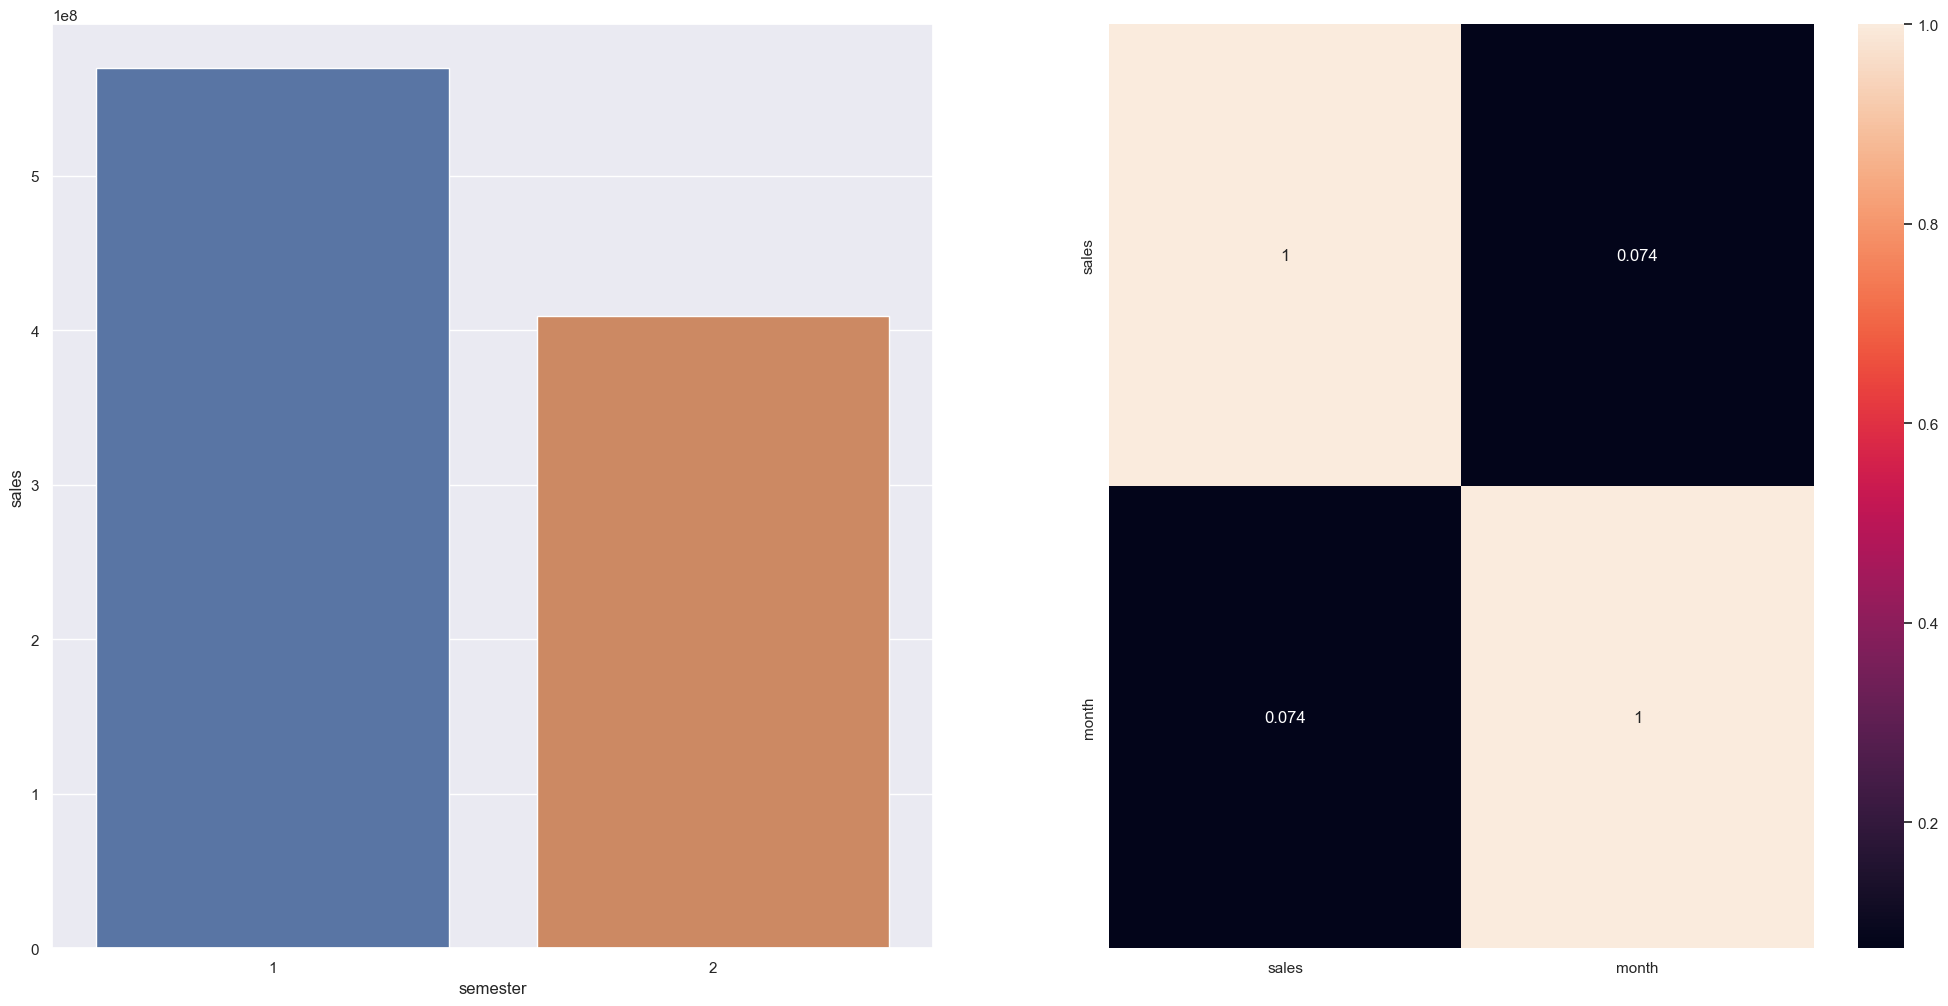

In [41]:
plt.subplot(1,2,1)
aux1=df4[['sales','month']].groupby('month').sum().reset_index()
aux1['semester'] = aux1['month'].apply(lambda x: 1 if x <= 6 else 2)
aux2=aux1[['sales','semester']].groupby('semester').mean().reset_index()
sns.barplot(data=aux2,x='semester',y='sales')
plt.subplot(1,2,2)
sns.heatmap(df4[['sales','month']].corr(method='pearson'), annot=True);

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**FALSA** Lojas vendem, na média, menos depois do dia 10.

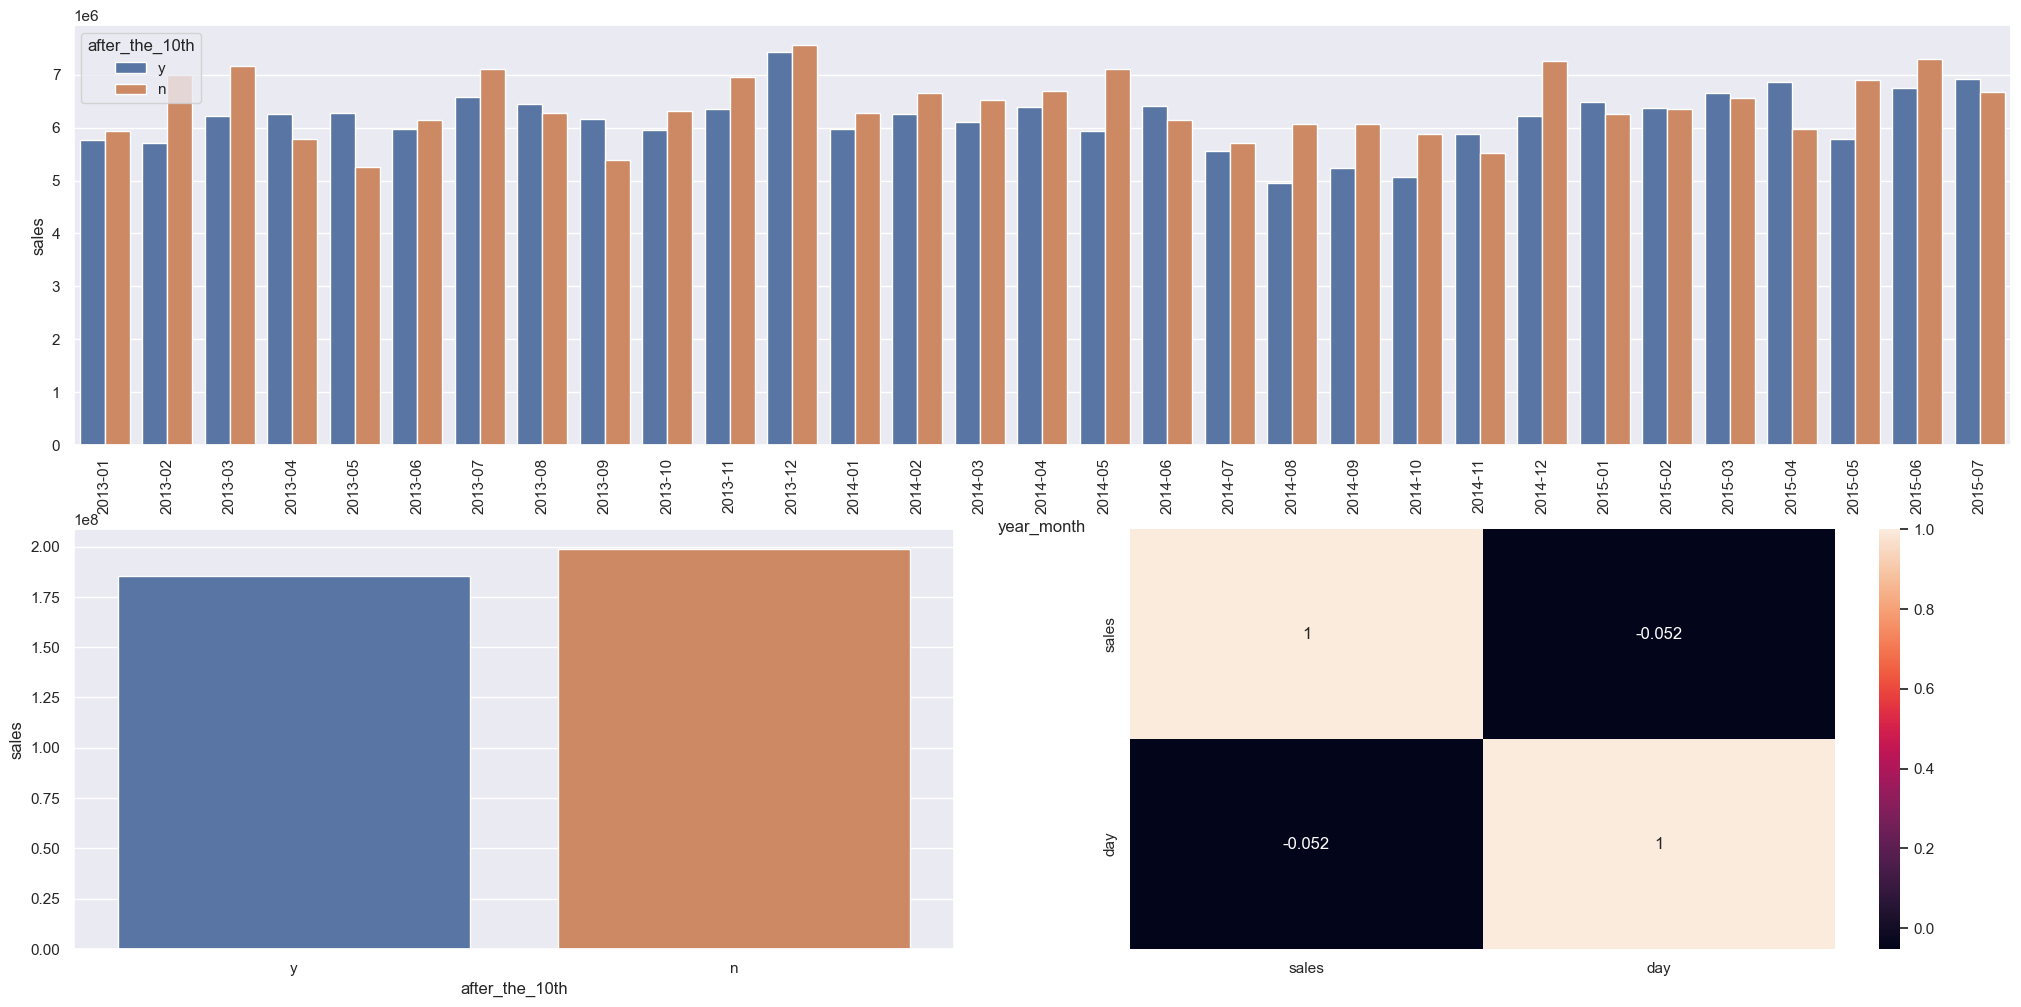

In [42]:
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
aux1=df4[['sales','year_month','day']].groupby(['year_month','day']).sum().reset_index()
aux1['after_the_10th'] = aux1['day'].apply(lambda x: 'y' if x >= 10 else 'n')
aux2=aux1[['sales','year_month','after_the_10th']].groupby(['year_month','after_the_10th']).mean().reset_index()
sns.barplot(data=aux2,x='year_month',y='sales',hue='after_the_10th',hue_order=['y','n'])
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux1=df4[['sales','day']].groupby('day').sum().reset_index()
aux1['after_the_10th'] = aux1['day'].apply(lambda x: 'y' if x >= 10 else 'n')
aux2=aux1[['sales','after_the_10th']].groupby('after_the_10th').mean().reset_index()
sns.barplot(data=aux2,x='after_the_10th',y='sales',order=['y','n']);

plt.subplot(grid[1,1])
sns.heatmap(df4[['sales','day']].corr(method='pearson'), annot=True);

#### **H11.** Lojas deveriam vender menos os finais de semana.

**VERDADEIRA**

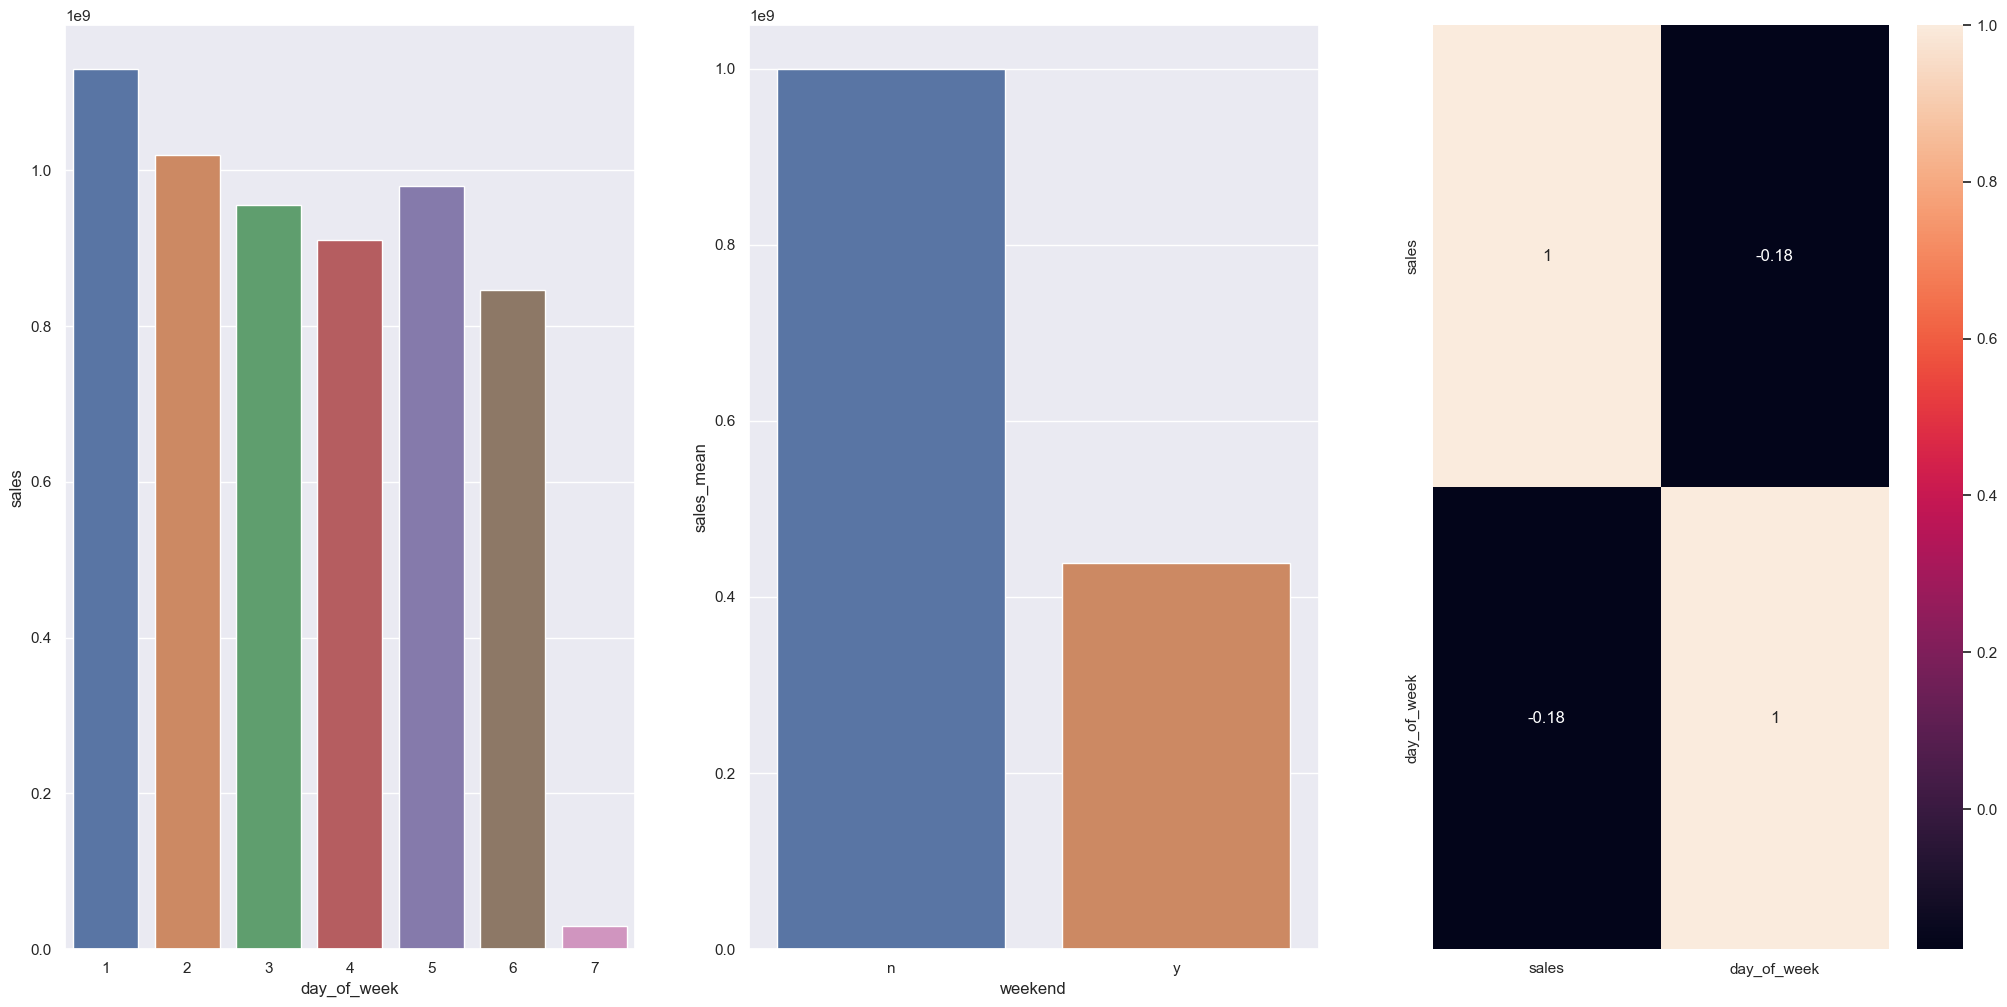

In [43]:
grid=gridspec.GridSpec(1,3)

plt.subplot(grid[0,0])
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data=aux1,x='day_of_week',y='sales')

plt.subplot(grid[0,1])
aux1['weekend'] = aux1['day_of_week'].apply(lambda x: 'y' if x>=6 else 'n')
aux2=aux1[['sales','weekend']].groupby('weekend').mean().reset_index()
aux2.columns=['weekend','sales_mean']
sns.barplot(data=aux2,x='weekend',y='sales_mean')

plt.subplot(grid[0,2])
sns.heatmap(df4[['sales','day_of_week']].corr(method='pearson'), annot=True);

#### **H12.** Lojas deveriam vender menos durante os feriados escolares. 

**FALSA** Lojas vendem, na média, mais durante os feriados escolares.

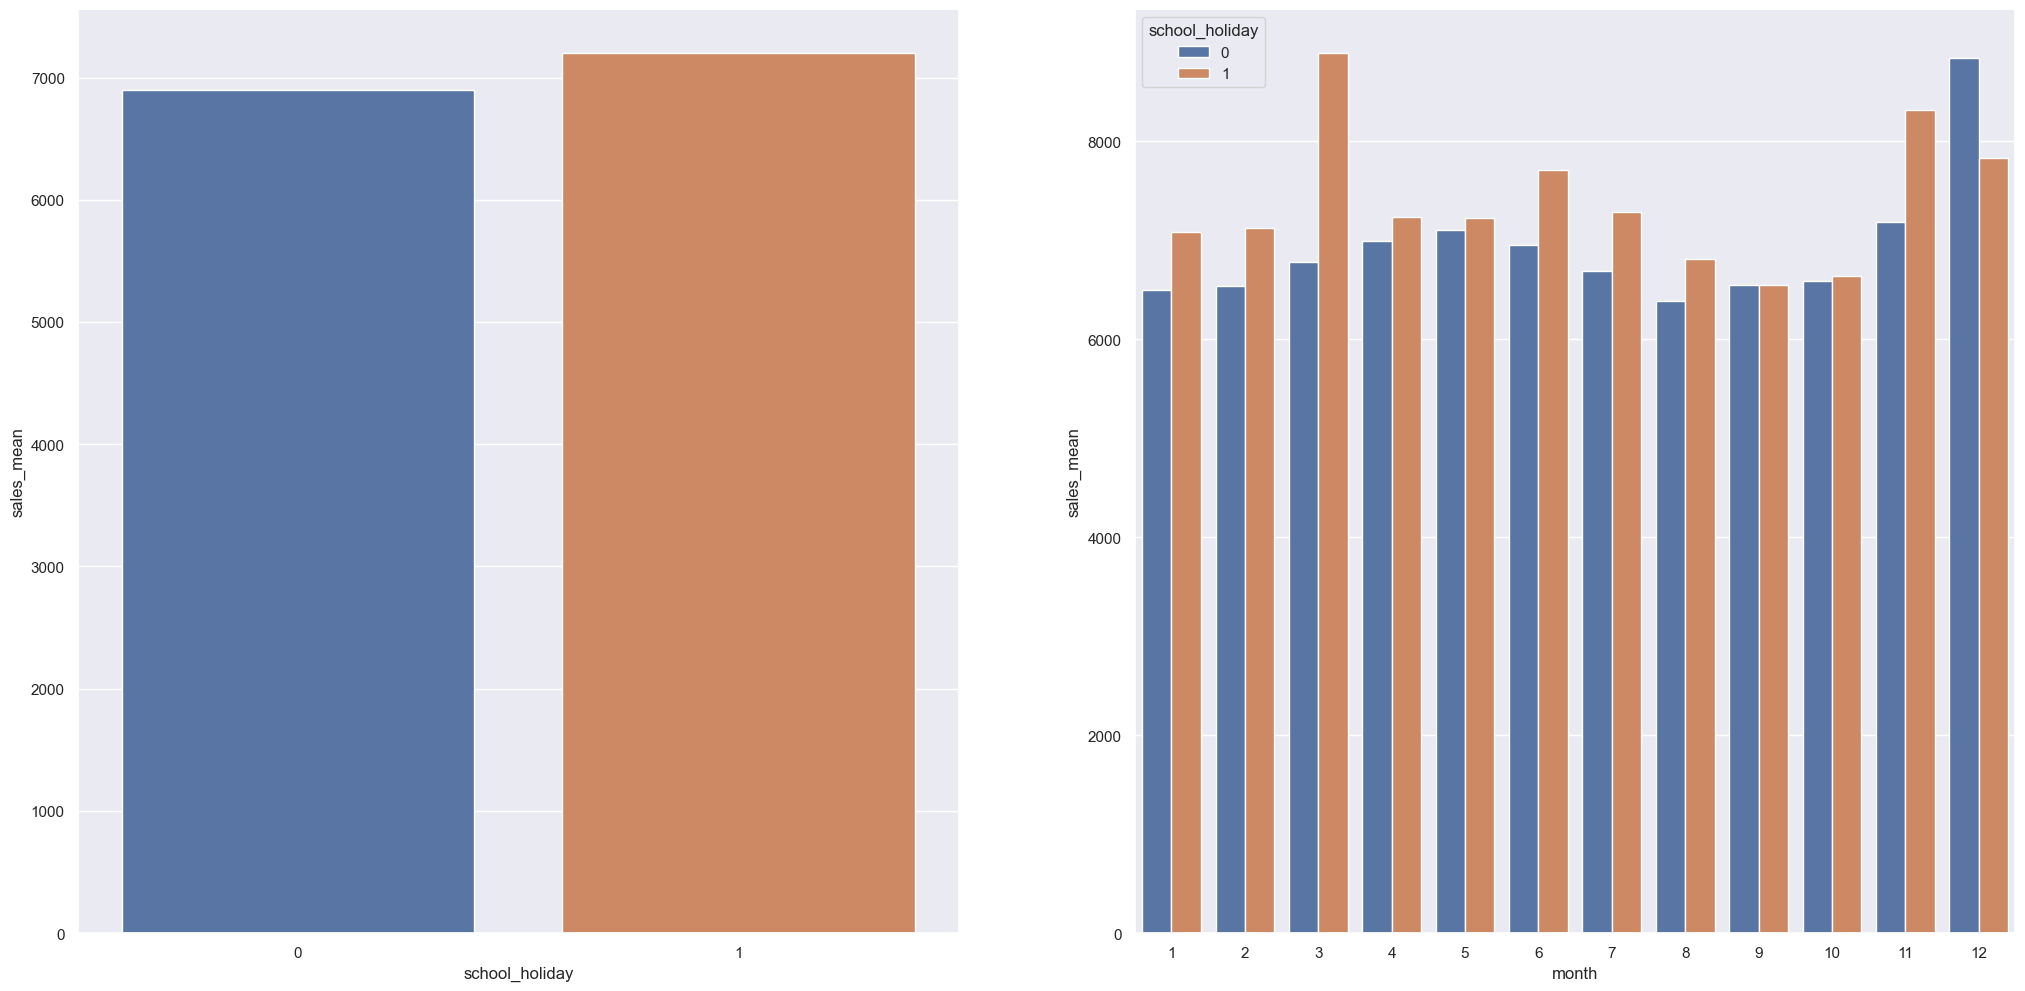

In [44]:
grid=gridspec.GridSpec(1,2)

plt.subplot(grid[0,0])
aux1=df4[['sales','school_holiday']].groupby('school_holiday').mean().reset_index()
aux1.columns = ['school_holiday','sales_mean']
sns.barplot(data=aux1,x='school_holiday',y='sales_mean')

plt.subplot(grid[0,1])
aux2=df4[['sales','month','school_holiday']].groupby(['month','school_holiday']).mean().reset_index()
aux2.columns = ['month','school_holiday','sales_mean']
sns.barplot(data=aux2,x='month',y='sales_mean',hue='school_holiday');

In [45]:
# vendas médias no setembro
aux2[aux2['month'] == 9]

,month,school_holiday,sales_mean
16,9,0,6547.975883
17,9,1,6541.818161


### 4.2.2. Resumo dos Resultados

In [46]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Verdadeira', 'assortment - média'],
      ['H2', 'Falsa', 'competition_distance - baixa'],
      ['H3', 'Falsa', 'competition_time_month - baixa'],
      ['H4', 'Verdadeira', 'promo_time_week - baixa'],
      ['H5', 'Verdadeira', 'promo_time_day - baixa'],
      ['H6', 'Falsa', 'promo2 - baixa'],
      ['H7', 'Falsa', 'state_holiday - média'],
      ['H8', 'Verdadeira', 'year - baixa'],
      ['H9', 'Falsa', 'month - baixa'],
      ['H10', 'Falsa', 'day - baixa'],
      ['H11', 'Verdadeira', 'day_of_week - média'],
      ['H12', 'Falsa', 'school_holiday - baixa']]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------------------------
H1           Verdadeira   assortment - média
H2           Falsa        competition_distance - baixa
H3           Falsa        competition_time_month - baixa
H4           Verdadeira   promo_time_week - baixa
H5           Verdadeira   promo_time_day - baixa
H6           Falsa        promo2 - baixa
H7           Falsa        state_holiday - média
H8           Verdadeira   year - baixa
H9           Falsa        month - baixa
H10          Falsa        day - baixa
H11          Verdadeira   day_of_week - média
H12          Falsa        school_holiday - baixa


## 4.3. Análise Multivariado

### 4.3.1. Atributos Numéricos

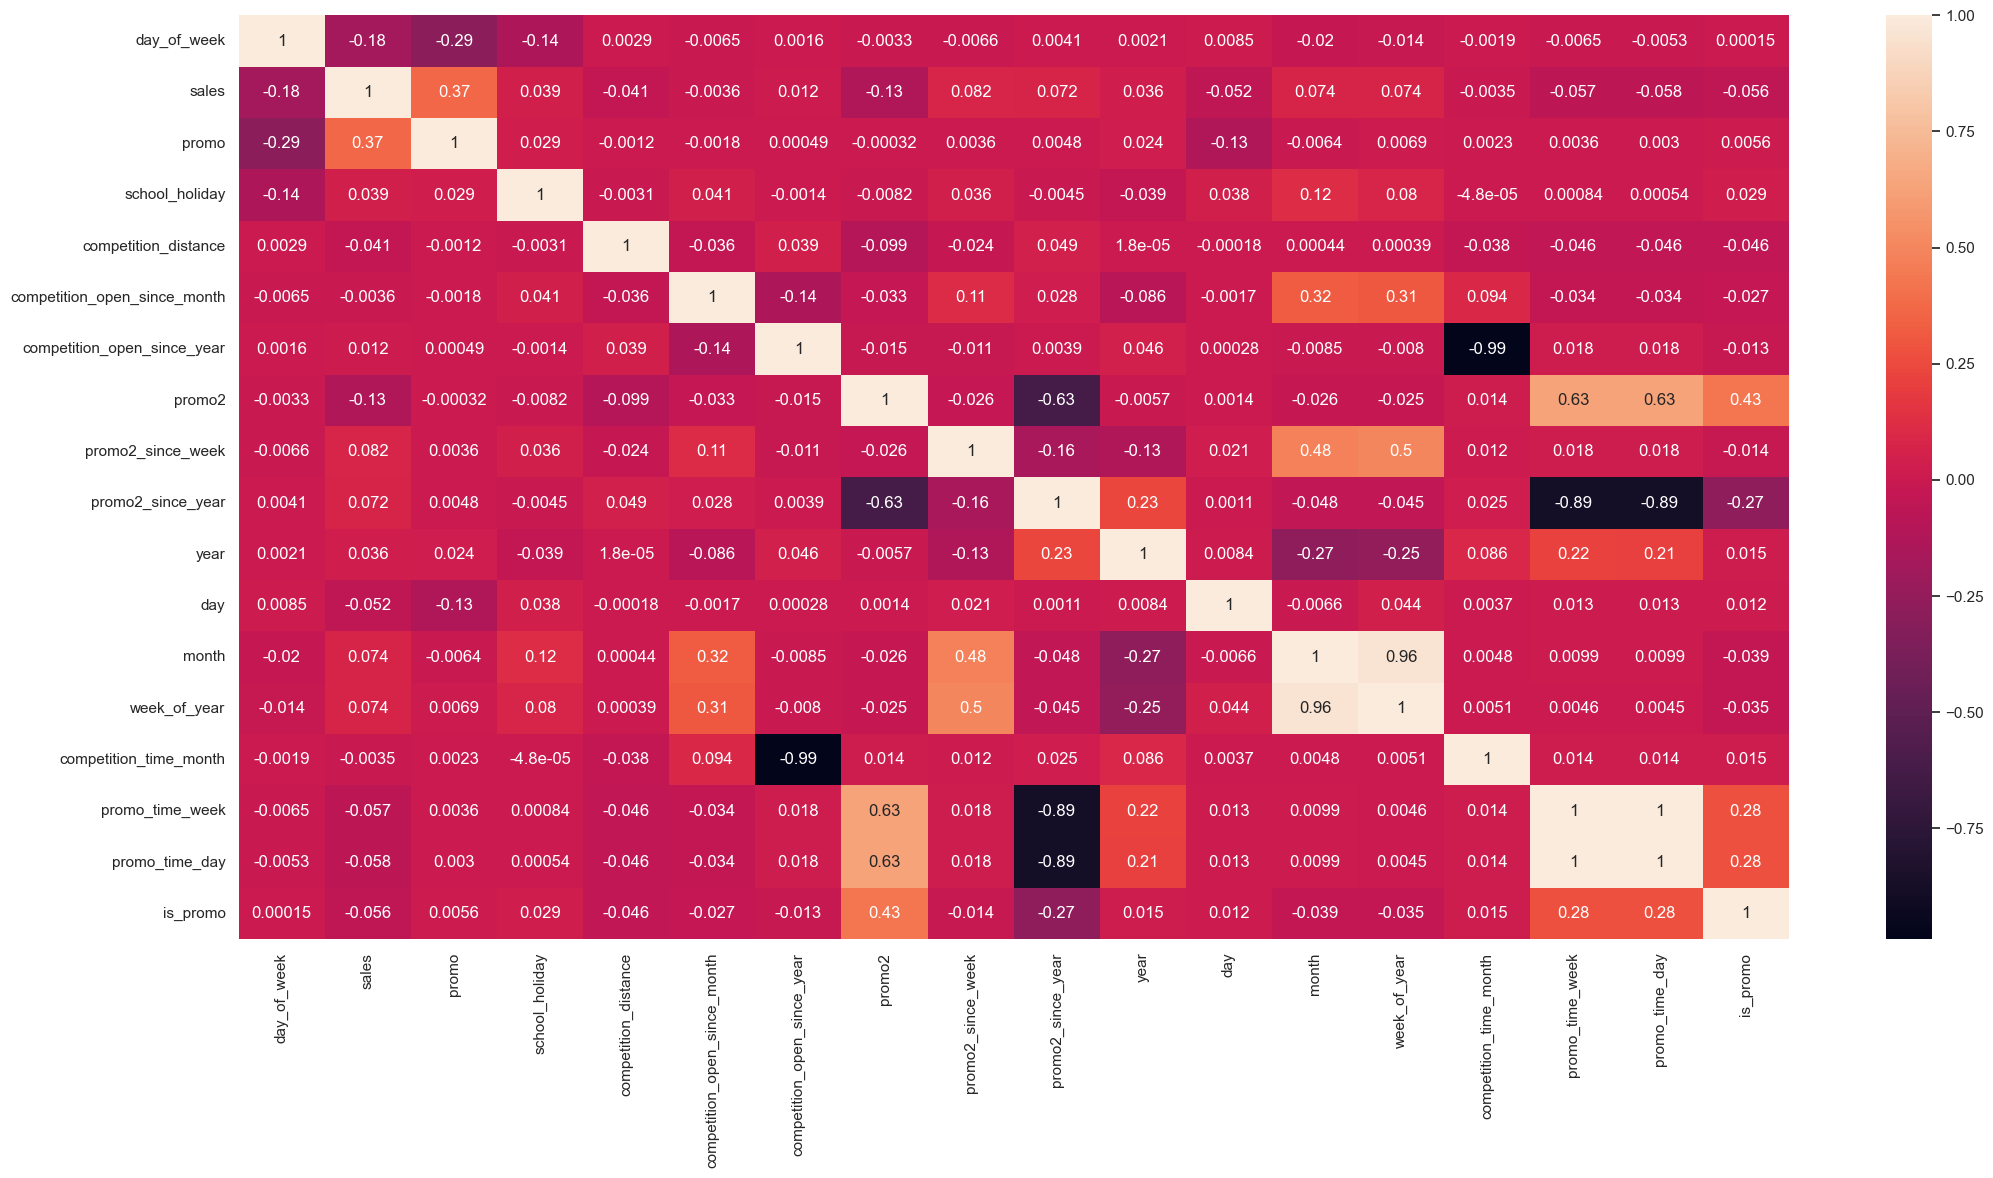

In [47]:
# correlação
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Atributos Categóricos

In [48]:
# apagar colunas
df4.drop(['year_week','year_month'], axis=1, inplace=True)

# atualizar cat_attributes
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

# mostrar dataframe
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


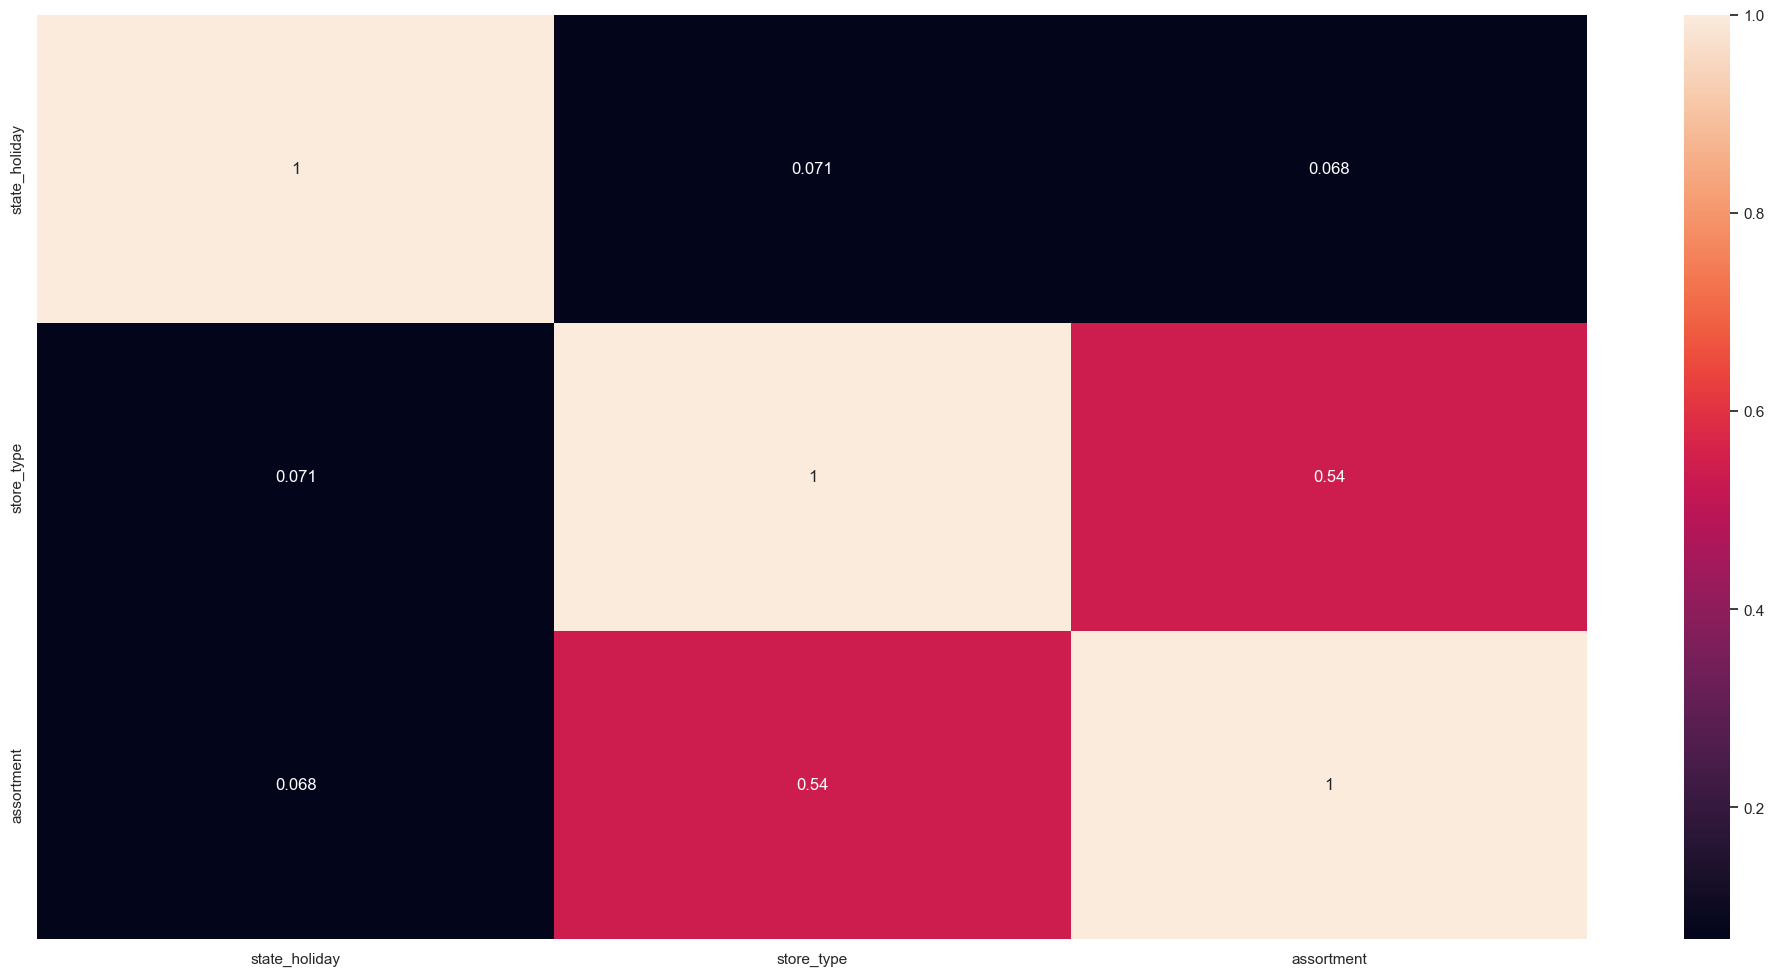

In [49]:
# correlação
plot_corr(cat_attributes, list(cat_attributes.columns));

# 5.0. PREPARAÇÃO DOS DADOS

In [50]:
df5 = df4.copy()

## 5.1. Rescaling

In [51]:
# atualizar atributos numéricos
num_attributes = df5.select_dtypes(include=['float64','int64'])

# mean, std, min, Q1, Q2, Q3, max
attri_num = num_attributes.describe().drop(index=['count']).rename(index={'25%': 'Q1', '50%': 'Q2', '75%': 'Q3'})

# range, skew, kurtosis
attri_ptp = num_attributes.agg(['ptp', 'skew', 'kurtosis']).rename(index={'ptp': 'range'})

# unique, top, mode
attri_str = num_attributes.astype(str).describe().drop(index=['count']).rename(index={'freq': 'mode'})

# concatenar
pd.concat([attri_num, attri_ptp, attri_str], axis=0).T

,mean,std,min,Q1,Q2,Q3,max,range,skew,kurtosis,unique,top,mode
store,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0,1114.0,0.000426,-1.198836,1115,562,942
day_of_week,3.52035,1.723712,1.0,2.0,3.0,5.0,7.0,6.0,0.01931,-1.259347,7,6,144052
sales,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0,41505.0,1.594929,4.854027,21733,5674,215
promo,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0,1.0,0.215824,-1.953425,2,0,467463
school_holiday,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0,1.0,1.551109,0.405939,2,0,680893
competition_distance,6033.232426,13719.980538,20.0,710.0,2330.0,6910.0,227580.0,227560.0,11.40767,174.659537,655,250.0,9210
competition_open_since_month,6.787355,3.309917,1.0,4.0,7.0,10.0,12.0,11.0,-0.048451,-1.231875,12,9,112179
competition_open_since_year,2010.331102,5.502628,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,-7.217323,123.903078,23,2013,170465
promo2,0.49867,0.499999,0.0,0.0,0.0,1.0,1.0,1.0,0.00532,-1.999976,2,0,423292
promo2_since_week,23.629083,14.288315,1.0,12.0,22.0,37.0,52.0,51.0,0.170399,-1.194815,52,14,69320


In [52]:
# instanciar scalers
rs = RobustScaler()
mms = MinMaxScaler()

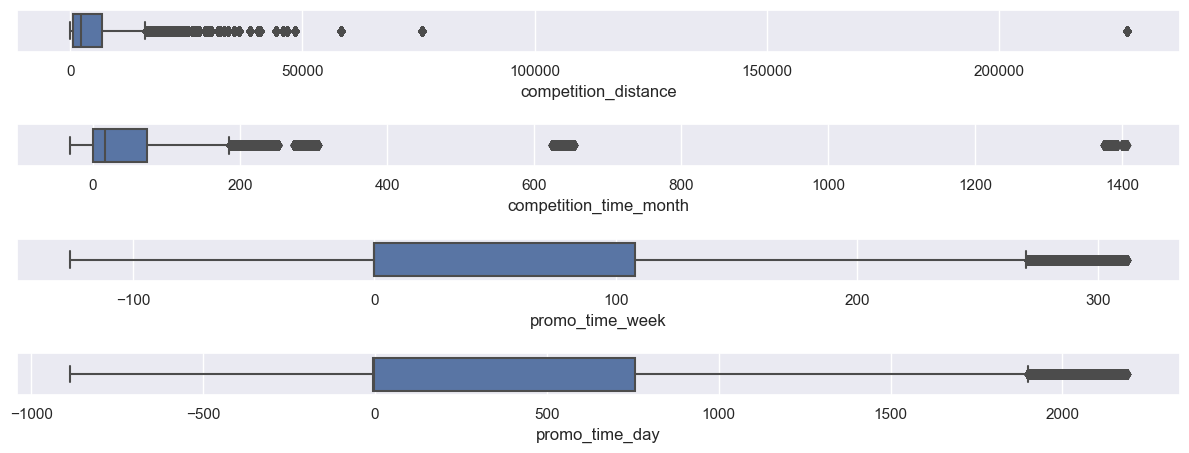

In [53]:
grid=gridspec.GridSpec(4,1)
plt.figure(figsize=(15,5))

plt.subplot(grid[0,0])
# competition_distance
sns.boxplot(data=df5, x='competition_distance')

plt.subplot(grid[1,0])
# competition_time_month
sns.boxplot(data=df5,x='competition_time_month')

plt.subplot(grid[2,0])
# promo_time_week transformada
sns.boxplot(data=df5,x='promo_time_week')

plt.subplot(grid[3,0])
# promo_time_day transformada
sns.boxplot(data=df5,x='promo_time_day');

# separação horizaontal entre subplots
plt.subplots_adjust(hspace=1.75)

In [54]:
# competition distance 
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# # salvar parâmetros para deploy
# pickle.dump(rs, open( './parameters/competition_distance_scaler.pkl', 'wb'))

# competition_time_month transformada
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# # salvar parâmetros para deploy
# pickle.dump(rs, open('./parameters/competition_time_month_scaler.pkl', 'wb'))

# transformar promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# # salvar parâmetros para deploy
# pickle.dump(mms, open('./parameters/promo_time_week_scaler.pkl', 'wb'))

# transformar promo_time_day
df5['promo_time_day'] = mms.fit_transform(df5[['promo_time_day']].values)

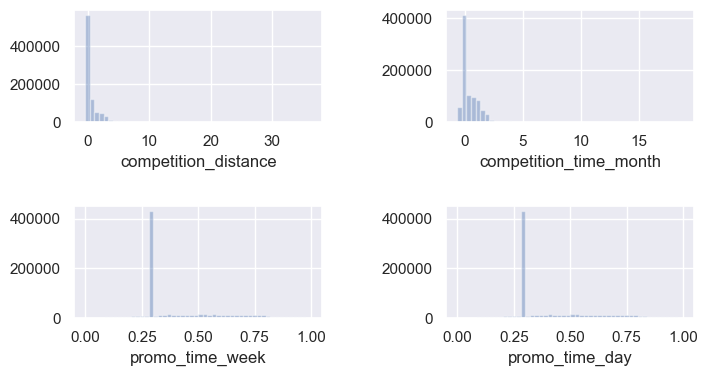

In [55]:
grid=gridspec.GridSpec(2,2)
plt.figure(figsize=(8,4))

plt.subplot(grid[0,0])
# plot competition_distance transformada
sns.distplot(df5['competition_distance'], kde=False);

plt.subplot(grid[0,1])
# plot competition_time_month transformada
sns.distplot(df5['competition_time_month'], kde=False);

plt.subplot(grid[1,0])
# plot promo_time_week transformada
sns.distplot(df5['promo_time_week'], kde=False);

plt.subplot(grid[1,1])
# plot promo_time_day transformada
sns.distplot(df5['promo_time_day'], kde=False);

# configurar separação horizontal e vertical
plt.subplots_adjust(hspace=.75, wspace=.5)

## 5.2. Encoding

In [56]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


In [57]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder() # instantiate encoder
df5['store_type'] = le.fit_transform(df5['store_type'])

# # salvar parâmetros para deploy
# pickle.dump(le, open('./parameters/store_type_encoder.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

## 5.3. Transformação de Natureza

In [58]:
# day of week
freq_day_of_week = 2. * np.pi/7
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * freq_day_of_week))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * freq_day_of_week))

# month
freq_month = 2. * np.pi/12
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * freq_month))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * freq_month))

# day 
freq_day = 2. * np.pi/30
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * freq_day))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * freq_day))

# week of year
freq_week_of_year = 2. * np.pi/52
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * freq_week_of_year))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * freq_week_of_year))

## 5.4. Transformação da Variável Resposta

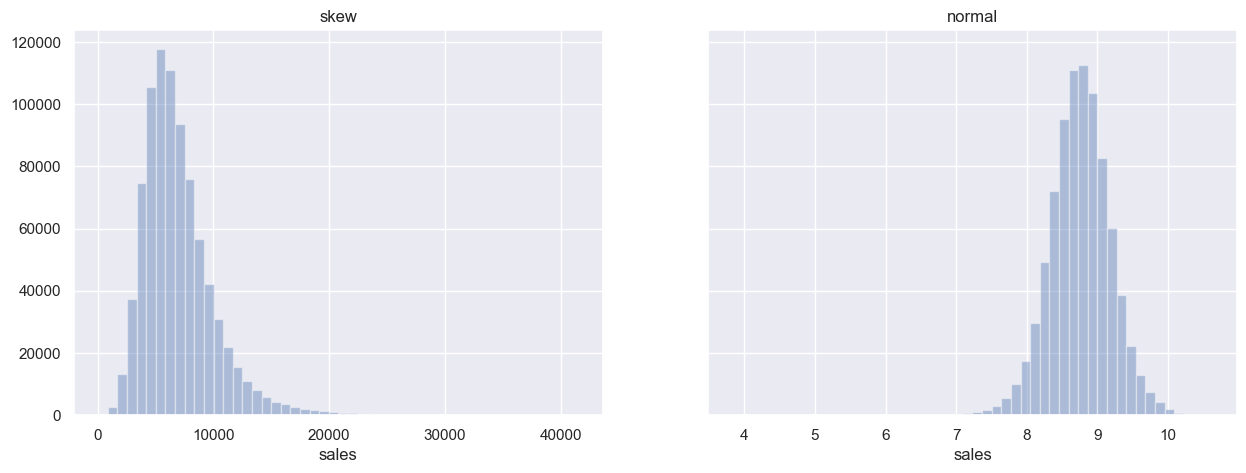

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
# fig.suptitle('Transformação da Variável Resposta')

# distribuição com skew
sns.distplot(df5['sales'], kde=False, ax=axes[0])
axes[0].set_title('skew')

# distribuição normal
sns.distplot(np.log(df5['sales']), kde=False, ax=axes[1])
axes[1].set_title('normal');

In [60]:
# aplicar transformação logaritmica
df5['sales'] = np.log(df5['sales'])

# 6.0. SELEÇÃO DE FEATURES

In [61]:
df6 = df5.copy()

In [62]:
# pre-seleção de features

# colunas usadas para derivar outras
cols_drop = ['week_of_year',      # data preparation - int
             'day',               # data preparation - int
             'month',             # data preparation - int
             'day_of_week',       # data preparation - int
             'promo_since',       # feature engineering - datetime
             'competition_since'] # feature engineering - datetime

# apagar colunas
df6 = df6.drop(cols_drop, axis=1)

## 6.1. Separar Dados em Treino e Teste

In [63]:
# data final para o treinamento
end_train = df6['date'].max() - datetime.timedelta(days=6*7) # ... minus last six weeks

# dataset de treinamento
X_train = df6[df6['date'] <= end_train].reset_index(drop=True)
y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] > end_train].reset_index(drop=True) # last six weeks
y_test = X_test['sales']
 
print(f'Data min. treinamento: {X_train["date"].min()}')
print(f'Data max. treinamento: {X_train["date"].max()}')

print(f'\nData min. de teste: {X_test["date"].min()}')
print(f'Data max. de teste: {X_test["date"].max()}')

Data min. treinamento: 2013-01-01 00:00:00
Data max. treinamento: 2015-06-19 00:00:00

Data min. de teste: 2015-06-20 00:00:00
Data max. de teste: 2015-07-31 00:00:00


## 6.2. Seletor de Features

In [64]:
# # dataset de treinamento
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # definir modelo
# rf = RandomForestRegressor(n_jobs=-1)

# # definir Boruta e treinar
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Selection

In [65]:
# # selected columns
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [66]:
# # boruta result above (OBS: code above takes around 50 min.)
# cols_selected_boruta = ['store',
#  'promo',
#  'store_type',
#  'assortment',
#  'competition_distance',
#  'competition_open_since_month',
#  'competition_open_since_year',
#  'promo2',
#  'promo2_since_week',
#  'promo2_since_year',
#  'competition_time_month',
#  'promo_time_week',
#  'promo_time_day', 
#  'day_of_week_sin',
#  'day_of_week_cos',
#  'month_cos',
#  'day_sin',
#  'day_cos',
#  'week_of_year_cos']
# # consideration: remove promo_time_day as sugested by multivariate analysis in EDA

## 6.3. Seleção Manual de Features

In [67]:
# resultado do Boruta
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_cos']

# adicionar colunas
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. MODELAGEM DE MACHINE LEARNING

In [68]:
# definir datasets de treinamento e teste
x_train = X_train[cols_selected_boruta]
x_test  = X_test[cols_selected_boruta]

# preparação dos dados para cross-validation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Baseline: Modelagem Usando a Média

In [69]:
# criar cópia do dateset de teste
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predição
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Modelo da Média', np.exp(y_test), np.exp(yhat_baseline))
baseline_result

,Modelo,MAE,RMSE,MAPE,MPE
0,Modelo da Média,1366.127691,1854.268938,20.791057,-3.483175


## 7.2. Modelo de Regressão Linear

In [70]:
# treinar modelo
lr = LinearRegression().fit(x_train, y_train)

# predição
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Regressão Linear', np.exp(y_test), np.exp(yhat_lr))
lr_result

,Modelo,MAE,RMSE,MAPE,MPE
0,Regressão Linear,1872.013236,2674.448448,29.615087,-8.903146


### 7.2.1. Cross Validation

In [71]:
lr_result_cv = cross_validation(x_training, 5, 'Regressão Linear', lr, verbose=False)
lr_result_cv

,Modelo,MAE_CV,MAPE_CV,RMSE_CV
0,Regressão Linear,2083.01 +/- 305.27,29.85 +/- 1.45,2965.89 +/- 473.78


## 7.3. Modelo de Regressão Linear Regularizado - Lasso

In [72]:
# treinar modelo
lrr = Lasso(alpha=.01).fit(x_train,y_train)

# predição
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.exp(y_test), np.exp(yhat_lrr))
lrr_result

,Modelo,MAE,RMSE,MAPE,MPE
0,Lasso,1893.368306,2747.480993,29.091126,-6.142622


### 7.3.1.  Cross Validation

In [73]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Modelo,MAE_CV,MAPE_CV,RMSE_CV
0,Lasso,2121.8 +/- 345.83,29.13 +/- 1.2,3064.48 +/- 507.7


## 7.4. Random Forest Regressor

In [74]:
# treinar modelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# predição
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.exp(y_test), np.exp(yhat_rf))
rf_result

,Modelo,MAE,RMSE,MAPE,MPE
0,Random Forest Regressor,729.614373,1077.651649,10.885696,-3.711009


### 7.4.1.  Cross Validation

In [75]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Modelo,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,845.16 +/- 220.89,11.66 +/- 2.38,1262.86 +/- 323.88


## 7.5. XGBoost Regressor

In [76]:
# treinar modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

# predição
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.exp(y_test), np.exp(yhat_xgb))
xgb_result

,Modelo,MAE,RMSE,MAPE,MPE
0,XGBoost Regressor,6665.436774,7318.393751,94.905538,94.905538


### 7.5.1. Cross Validation

In [77]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Modelo,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor,7064.74 +/- 594.59,95.11 +/- 0.2,7727.09 +/- 695.08


## 7.6. Comparação de Performance

### 7.6.1. Performance para um KFold

In [78]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Modelo,MAE,RMSE,MAPE,MPE
0,Random Forest Regressor,729.614373,1077.651649,10.885696,-3.711009
0,Modelo da Média,1366.127691,1854.268938,20.791057,-3.483175
0,Regressão Linear,1872.013236,2674.448448,29.615087,-8.903146
0,Lasso,1893.368306,2747.480993,29.091126,-6.142622
0,XGBoost Regressor,6665.436774,7318.393751,94.905538,94.905538


### 7.6.2. Performance Real - Cross Validation

In [79]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE_CV')

,Modelo,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor,845.16 +/- 220.89,11.66 +/- 2.38,1262.86 +/- 323.88
0,Regressão Linear,2083.01 +/- 305.27,29.85 +/- 1.45,2965.89 +/- 473.78
0,Lasso,2121.8 +/- 345.83,29.13 +/- 1.2,3064.48 +/- 507.7
0,XGBoost Regressor,7064.74 +/- 594.59,95.11 +/- 0.2,7727.09 +/- 695.08


# 8.0. AJUSTE FINO DE HIPERPARÂMETROS

## 8.1. Random Search

In [80]:
# # conjunto de parâmetros
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [81]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # escolher parâmetros aleatoriamente
#     hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#     print(hp)
   
#     # modelo
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'], 
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2. Modelo Final 

In [82]:
# parâmetros escolhidos 
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [83]:
# modelo
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'], 
                                   max_depth=param_tuned['max_depth'], 
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# predição
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Modelo,MAE,RMSE,MAPE,MPE
0,XGBoost Regressor,785.967388,1119.856377,11.930345,-2.46308


In [84]:
# salvar modelo treinado
pickle.dump(model_xgb_tuned, open('model/model_rossmann_xgb_v2.pkl', 'wb'))

# 9.0. INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [92]:
df9 = X_test[cols_selected_boruta_full]

In [93]:
# transformação
df9['sales'] = np.exp(df9['sales'])
df9['predictions'] = np.exp(yhat_xgb_tuned)

## 9.1. Performance de Negócio 

In [94]:
# predição média por loja
df91 = df9[['store', 'predictions']].groupby('store').mean().reset_index()

# vendas médias por loja
df91_aux0 = df9[['store', 'sales']].groupby('store').mean().reset_index()

# MAE por loja
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})

# MAPE por loja
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# juntar resultados acima
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')
df93 = pd.merge(df91_aux0, df92, how='inner', on='store')

# cenários
df93['worst_scenario'] = df93['predictions'] - df93['MAE']
df93['best_scenario']  = df93['predictions'] + df93['MAE']

In [95]:
df93.sort_values('MAPE', ascending=False).head()

,store,sales,predictions,MAE,MAPE,worst_scenario,best_scenario
291,292,7328.333333,5706.808105,3546.772800,64.036758,2160.035305,9253.580905
908,909,15827.863636,9550.439453,8244.496826,54.316309,1305.942627,17794.936279
169,170,4107.611111,5624.938477,1517.327298,37.718315,4107.611179,7142.265774
285,286,3663.472222,4594.914551,943.169922,35.029009,3651.744629,5538.084473
875,876,11256.136364,8543.924805,4191.556818,34.110720,4352.367987,12735.481623


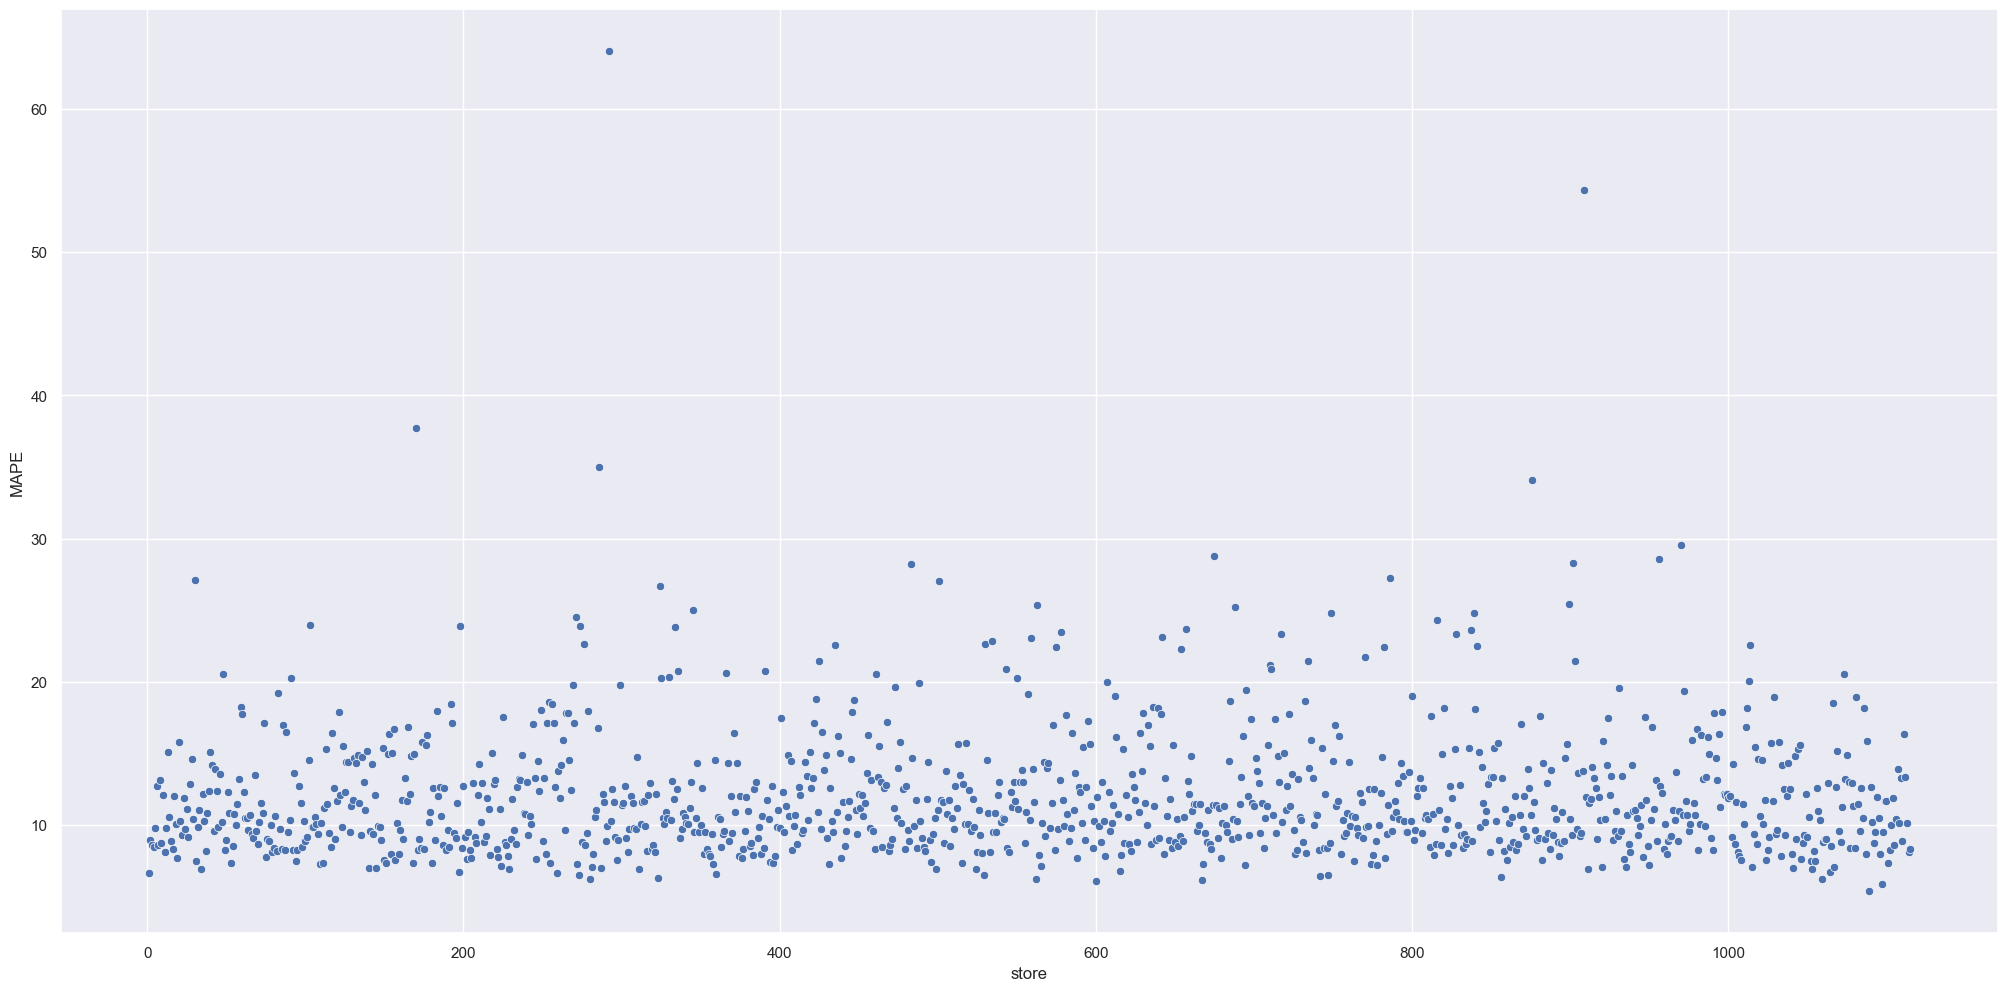

In [96]:
# plot resultados
sns.scatterplot(x='store', y='MAPE', data=df93);

In [97]:
print(f'Média do MAPE: {df93["MAPE"].mean():.0f}%')

Média do MAPE: 12%


### 9.1.1 Performance Total

In [98]:
df94 = df93[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0:'values'})
df94['values'] = df94['values'].map('{:,.2f}'.format)
df94

,scenario,values
0,predictions,"7,730,879.50"
1,worst_scenario,"6,851,053.70"
2,best_scenario,"8,610,705.24"


## 9.2. Performance do Modelo de Machine Learning

In [99]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

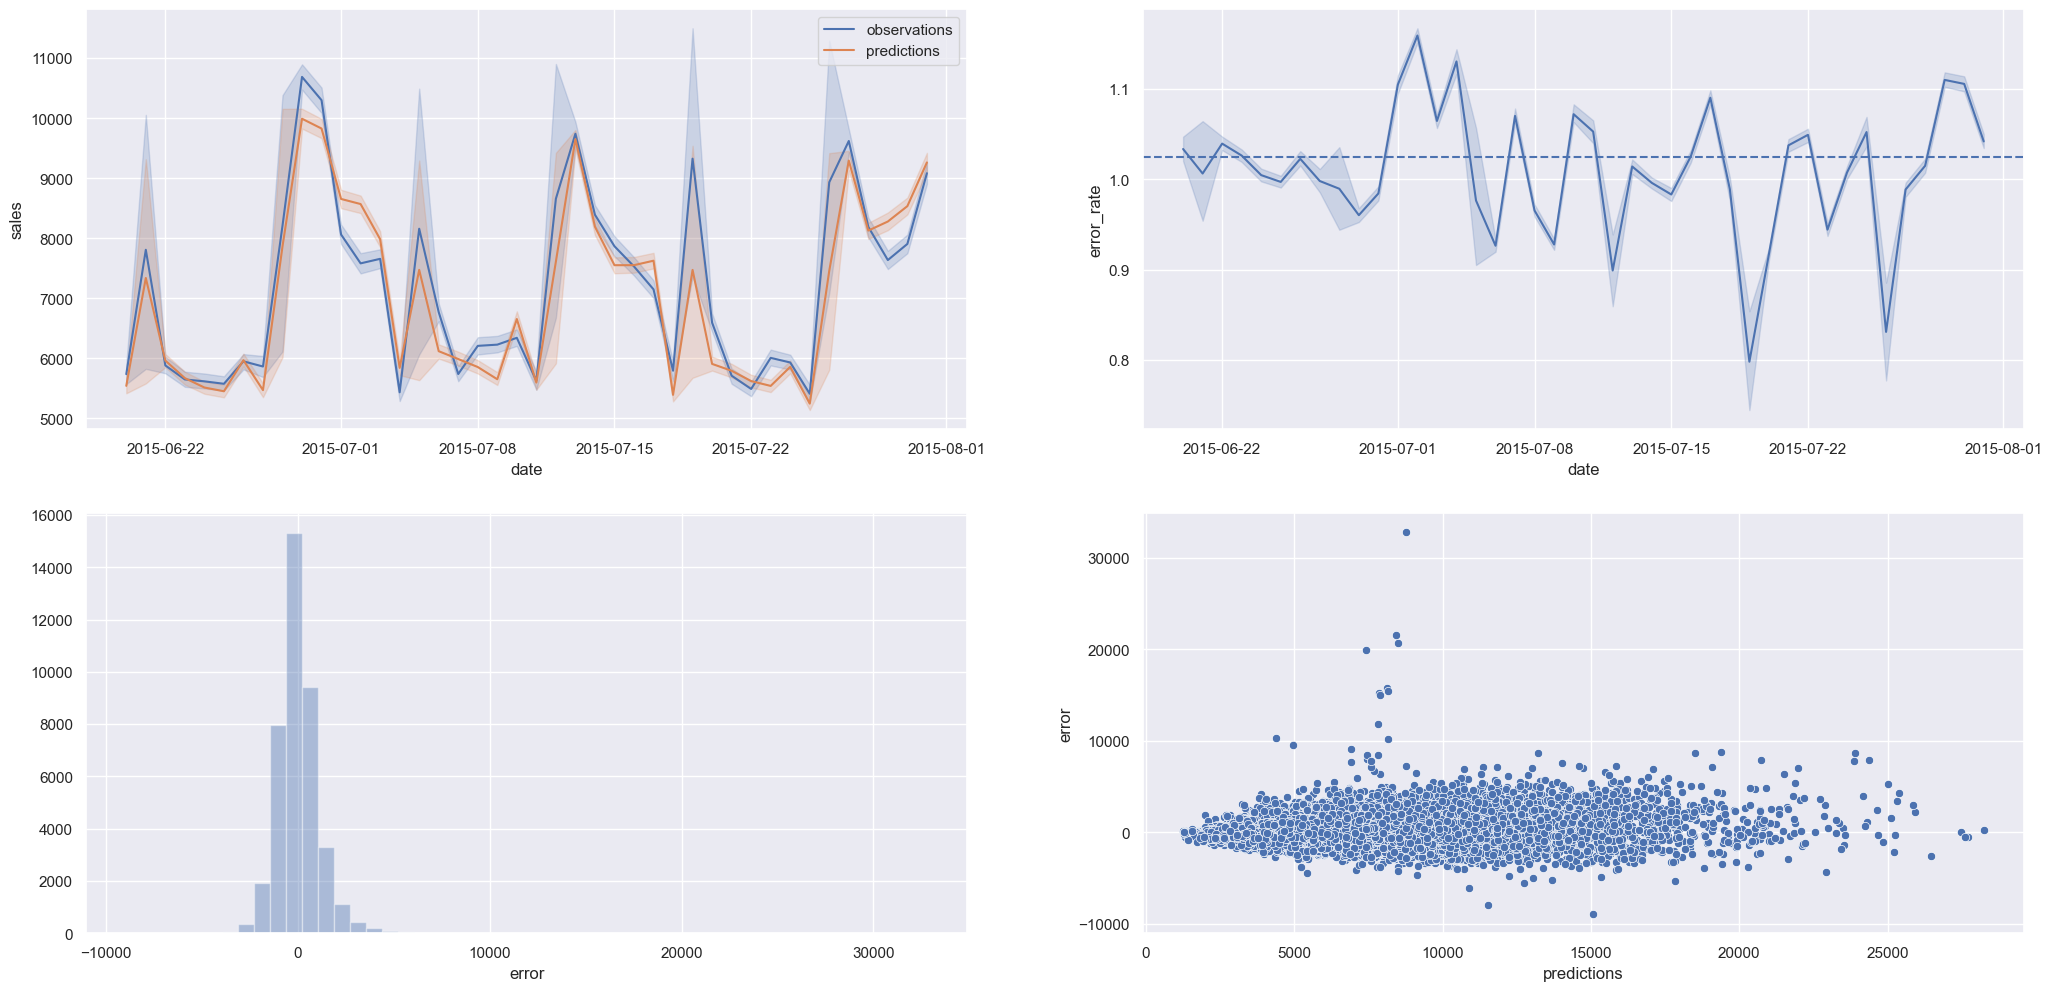

In [100]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='observations')
sns.lineplot(x='date', y='predictions', data=df9, label='predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(df9['error_rate'].mean(), linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'], kde=False)

plt.subplot(2, 2, 4)
sns.scatterplot(data=df9, x='predictions', y= 'error');